In [2]:
# ml libraries
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from scipy.stats import uniform
import numpy as np

# nlp libraries
import nltk
from nltk.corpus import stopwords
import spacy

import re
import pickle
import random

# modules defined in this project
from supporting_modules.text_cleaning import PATTERNS
import supporting_modules.corpus_preprocessing as scp
import supporting_modules.text_cleaning as stc
import supporting_modules.models_preparation as smp
import supporting_modules.data_visualization as sdv

# step 0: Load data from dataset

Firstly, we need to load the dataset for further analysis. In this case, it will be the dataset named **"Large Movie Review Dataset"**. It is downloaded from https://ai.stanford.edu/~amaas/data/sentiment/

The sentiment values in the text corpus from Stanford Dataset are either positive or negative. More info about these data is in `README` file. After loading, the data is of sklearn Bunch type, so we have to retrieve a list of text data and numpy.ndarray with the labels.

This data is not included in the project. To use them, you can download them from the mentioned website and then unpack them to the appropriate directory.

In my case, the directory is one level above the project's main directory.

### Required imports

In [2]:
train_data = load_files("../datasets/aclImdb_v1/aclImdb/train")
test_data = load_files("../datasets/aclImdb_v1/aclImdb/test")

reviews_train, y_train = train_data.data, train_data.target
reviews_test, y_test = test_data.data, test_data.target

The types of each data element are listed below. As we can see the data are saved as bytes. The length of the training data set is equal to 75,000. In the README file, it was mentioned that the quantity of positive and negative reviews is equal to 50,000 (per 25,000 in training and test part accordingly). The difference equal to 50,000 is caused by data labeled as 'unsup'. This part of the data includes an additional 50,000 unlabeled documents for unsupervised learning.

In the first part of the project, these data will not be needed. Therefore, they will be subtracted from the training pool (there is no data with this label in the test pool).

In [3]:
print(f"train_data data type: {type(train_data)}")
print(f"reviews_train type: {type(reviews_train)}")
print(f"the type of single review: {type(reviews_train[0])}")
print(f"reviews_test type: {type(reviews_test)}")
print(f"text_train data length: {len(reviews_train)}")
print(f"text_test data length: {len(reviews_test)}")

train_data data type: <class 'sklearn.utils._bunch.Bunch'>
reviews_train type: <class 'list'>
the type of single review: <class 'bytes'>
reviews_test type: <class 'list'>
text_train data length: 75000
text_test data length: 25000


In [4]:
# The data in the training set are distributed in the proportions of 12500, 12500, 50000
# In the next steps I remove those items that are 'unsup' 

print(f"The proportions of the data distribution: {np.bincount(y_train)}")
print(f"Numeric values of labels: {np.unique(y_train, return_counts=True)}")
print(f"Label names: {train_data.target_names}\n")

print(f"The proportions of the data distribution: {np.bincount(y_test)}")
print(f"Numeric values of labels: {np.unique(y_test, return_counts=True)}")
print(f"Label names: {test_data.target_names}\n")

The proportions of the data distribution: [12500 12500 50000]
Numeric values of labels: (array([0, 1, 2]), array([12500, 12500, 50000]))
Label names: ['neg', 'pos', 'unsup']

The proportions of the data distribution: [12500 12500]
Numeric values of labels: (array([0, 1]), array([12500, 12500]))
Label names: ['neg', 'pos']



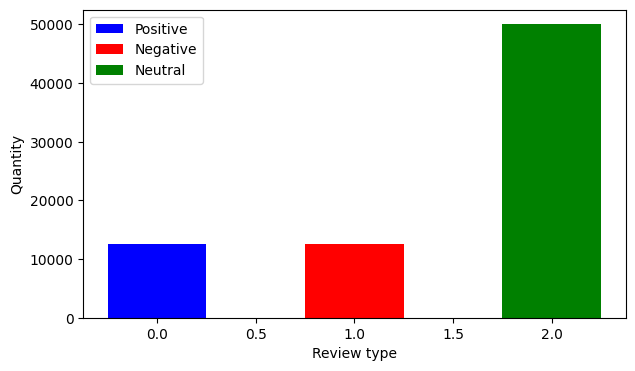

In [5]:
#  'unsup' data are two times greater than 'pos' and 'neg' because this is whole data for unsupervised learning
# Therefore its quantity is equal to sum of 'pos'  and 'neg' in both data bunches (train and test) for supervised learning

sdv.count_per_label(np.bincount(y_train), ('Positive', 'Negative', 'Neutral'))

In [6]:
# Let's see what the reviews look like

print("POSITIVE REVIEW EXAMPLE:\n".upper(), reviews_train[3], "\n\n", "*" * 100, "\n")
print("NEGATIVE REVIEW EXAMPLE:\n", reviews_train[126])

POSITIVE REVIEW EXAMPLE:
 b"Dan Katzir has produced a wonderful film that takes us on a roller-coaster ride through a real romance set in the troubles surrounding modern Israel.<br /><br />For anyone who's ever been in love, the film brings back the uncertainties, the insecurities and heartache that make love so bitter-sweet. The atmosphere of fear and isolation that came with the difficult times in Israel at that time just serve to intensify the feeling. Instantly, you are drawn in to Dan's plight, and you can't fail to be deeply moved.<br /><br />You can't write drama and passion like this - the contrast between the realities of Dan's desperate, snatched relationship with Iris, and the realities of a state in turmoil make this eminently watchable. If you have an ounce of passion, and have ever been in love, see this film." 

 **************************************************************************************************** 

NEGATIVE REVIEW EXAMPLE:
 b"This film comes as the ultima

## Remove the data without labels

The data are cleaned using function defined in `additional_modules/corpus_preprocessing`. 

After this action we'll have balanced binary data in both datasets (training and test). The data after applying stc.clear_reviews_from_dataset() function looks like:

In [7]:
reviews_train_binary, y_train_binary = scp.clear_reviews_from_dataset(y_train, reviews_train)

In [8]:
# Our data after applying stc.clear_reviews_from_dataset() function

print(f"The proportions of the data distribution: {np.bincount(y_train_binary)}")
print(f"Numeric values of labels: {np.unique(y_train_binary, return_counts=True)}")

The proportions of the data distribution: [12500 12500]
Numeric values of labels: (array([0, 1]), array([12500, 12500]))


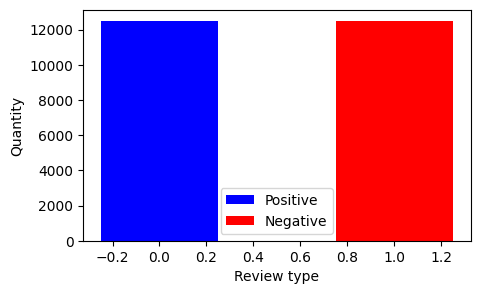

In [9]:
# train data

sdv.count_per_label(np.bincount(y_train_binary), ('Positive', 'Negative', 'Neutral'))

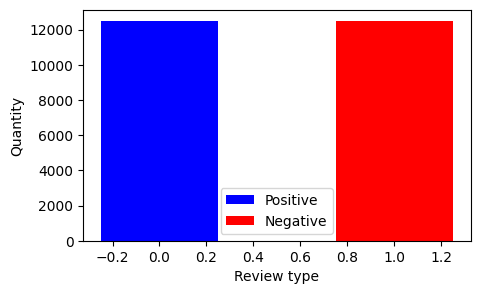

In [10]:
# test data

sdv.count_per_label(np.bincount(y_test), ('Positive', 'Negative', 'Neutral'))

## Checking the corpus for duplicates and removing them if any

Unique reviews in both datasets and difference between unique and whole quantity in train and test:

In [11]:
print("unique reviews in train data: ", len(set(reviews_train_binary)), " / all train reviews: ", len(reviews_train_binary), "\n")
print(f"there are {len(reviews_train_binary) - len(set(reviews_train_binary))} duplicated reviews in train data")

unique reviews in train data:  24904  / all train reviews:  25000 

there are 96 duplicated reviews in train data


In [12]:
print("unique reviews in test data: ", len(set(reviews_test)), " / all test reviews: ", len(reviews_test), "\n")
print(f"there are {len(reviews_test) - len(set(reviews_test))} duplicated reviews in test data")

unique reviews in test data:  24801  / all test reviews:  25000 

there are 199 duplicated reviews in test data


Duplicate texts can probably cause noise in the data and favor words that appear in duplicate documents. Their removal seems important for the training set (reviews_train_binary, y_train_binary) - because our models will learn from these ones. 

To avoid it these redundant documents will be removed from our datasets. The function `drop_duplicates_from_corpus` that removes them is defined in the module `supporting_modules/corpus_preprocessing`.

In [13]:
# Remove duplicates from the train dataset

reviews_train_binary, y_train_binary = scp.drop_duplicates_from_corpus(reviews_train_binary, y_train_binary)

In [14]:
# data after removing duplicated reviews

print("unique reviews in train data: ", len(set(reviews_train_binary)), " / all train reviews: ", len(reviews_train_binary), "\n")
print(f"there are {len(reviews_train_binary) - len(set(reviews_train_binary))} duplicated reviews in train data \n")

print(f"Quantity of labels: {len(y_train_binary)}")

unique reviews in train data:  24904  / all train reviews:  24904 

there are 0 duplicated reviews in train data 

Quantity of labels: 24904


## Word quantity per review histograms

Below there are the histograms for data before text cleaning. The most common length of reviews  is between (more-less) 70 and 400 words per text in both parts (train and test). In the next steps, the documents will be cleaned so these values will be decreased. 

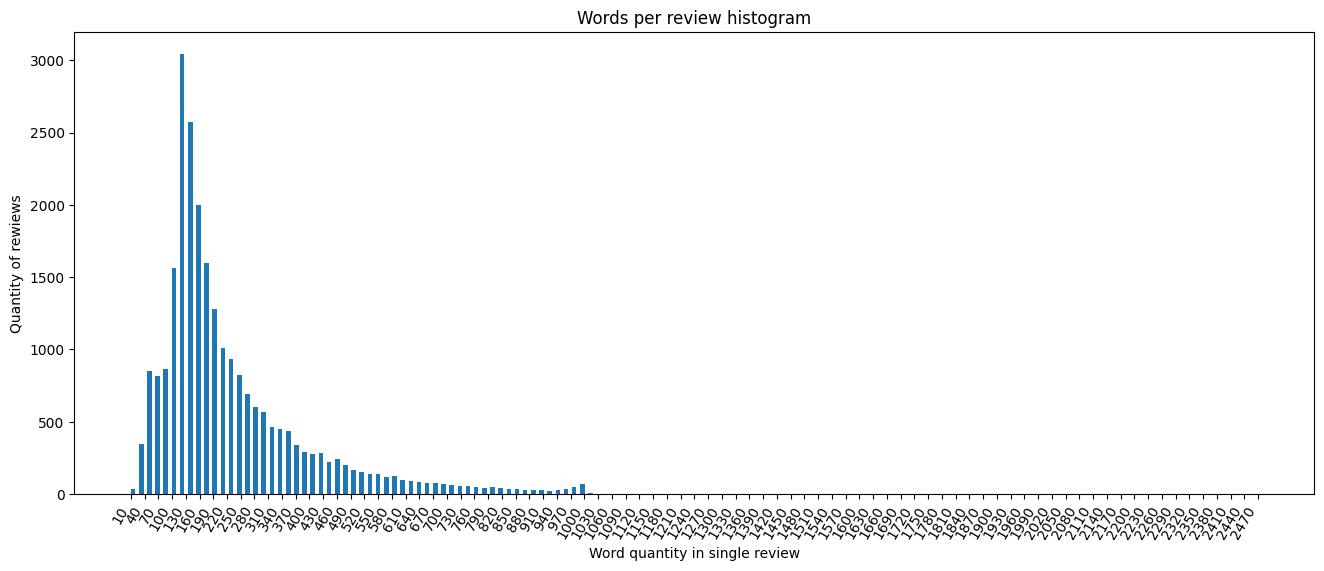

In [15]:
word_counts = sdv.make_count_histogram(reviews_train_binary, 30)

In [16]:
# Two the shortest reviews in our train dataset

for text in reviews_train_binary:
    if len(text.split()) <= min(list(word_counts.keys())):
        print(text)

b"I wouldn't rent this one even on dollar rental night."
b'This movie is terrible but it has some good effects.'


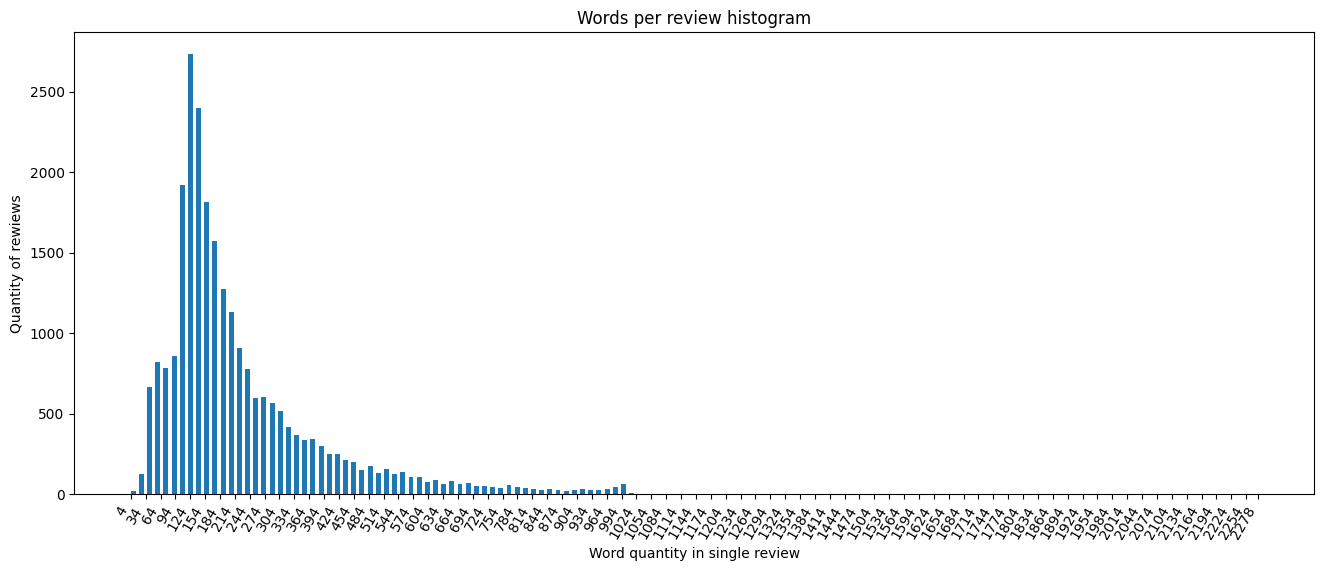

In [17]:
word_counts = sdv.make_count_histogram(reviews_test, 30)

In [18]:
# shortest review in our test dataset

for text in reviews_test:
    if len(text.split()) <= min(list(word_counts.keys())):
        print(text)

b'Primary plot!Primary direction!Poor interpretation.'


# step 1: Text data cleaning

## Convert all letters to lowercase

In the case of sentiment analysis in movie reviews conversion to lowercase can be helpful in the next steps like tokenization, stemming, and so on.

In [19]:
reviews_train_binary = [review.lower() for review in reviews_train_binary]

### Checking if the text contains HTML tags

 Let's check if there are any HTML tags in our reviews and if so let's take a look at what they look like.
The checking is made using the function **`get_occurance_in_dataset()`** defined in **`supporting_modules/text_cleaning`** (aliased as **`srt`** in this notebook). 
As it is visible below not all results are proper HTML tags some of them look like such elements but they aren't. For instance, in the first returned element we have an open sign "<" directly behind this sign there's the space and the regular text data till the closing proper HTLM tag \<br /\> . A similar situation in the next three returned and the last one. The rest of the returned values are proper or almost proper tags.

In [20]:
list_of_elements, quantity = stc.get_occurance_in_dataset(reviews_train_binary)

print(quantity, " elements found.\n\nUnique items found:\n")
list_of_elements

101630  elements found.

Unique items found:



{"< $600 per screen its opening weekend, and just over $400 each, after its month's theater run in latter 2002. overall gross was $261k, which i'd doubt could cover cast and crew's hotel and food for a week on location.<br />",
 '< and make notes for my partial "review" to show how foolish the movie is. "resident evil" (horror) or "dude, where\'s my car?" (comedy) i can watch over and over again and still enjoy! but this...!<br />',
 '< than 30 minutes of watching, being bored and irritated. <br />',
 '< who was to be a victim, but woman-power trumps evil scientist every time.<br />',
 '</em>',
 '</i>',
 '</spoiler>',
 '<3 <br />',
 '<<<sigh>',
 '<=8.<br />',
 '<br />',
 '<em>',
 '<grin>',
 '<hr>',
 '<http://rogerebert.suntimes.com/apps/pbcs.dll/section?category=answerman>',
 '<i>',
 '<sp?) classic "romeo & juliet". guess i\'ll have to rent that next.<br />',
 '<spoiler>'}

## Removal of HTML tags from the reviews

Before removing the HTML tags, problematic fragments found as tags but which are not - should be taken into attention. To remove such elements - the replacement "\<sp\\?\\)|<+ " by "" seems like a good idea - because we have in such cases either tags started with "\<" + space or "\<sp?)".

After removing them, only tags and tag-like elements that look redundant will remain in the documents. Then these elements will be replaced by a blank string. 

Both activities are performed using function **`clear_substr_in_texts()`** defined in **`supporting_modules/text_cleaning`** (aliased as **`srt`** in this notebook). 



In [21]:
# remove tag-like elements from train data
reviews_train_binary = stc.clear_substr_in_texts(reviews_train_binary, \
                                                 pattern=re.compile(r"<sp\?\)|<+ "))

# show if tag-like element list looks ok

list_of_elements, quantity = stc.get_occurance_in_dataset(reviews_train_binary)
print("\nTAGS LEFT:")
print(quantity, " elements found.\n\nUnique items found after last opperation:\n")
list_of_elements


REMOVED SUBSTRINGS SAMPLE:
 {'<<<<<<<<<<<<<<<<<<<< ', '< ', '<<<<<<<<<<<< ', '<sp?)', '<<<<<<<<<<<<<<<<<<<<<<<< '}

10 elements removed

TAGS LEFT:
101630  elements found.

Unique items found after last opperation:



{'</em>',
 '</i>',
 '</spoiler>',
 '<3 <br />',
 '<<<sigh>',
 '<=8.<br />',
 '<br />',
 '<em>',
 '<grin>',
 '<hr>',
 '<http://rogerebert.suntimes.com/apps/pbcs.dll/section?category=answerman>',
 '<i>',
 '<spoiler>'}

The occurrence of a tag containing at least one "<" character and a space occurs quite often, therefore both the regex for removing full HTML tags and those "<+ " (at least one < character followed by a space) will be added to the permanent PATTERNS dictionary in the module `supporting_modules/text_cleaning`. 

### Remove HTML tags from train data

Finally let's remove remaining tags and tags-like elements. 

In [22]:
reviews_train_binary = stc.clear_substr_in_texts(reviews_train_binary, \
                                                 pattern=PATTERNS['html_tags'])

# show whether any tag-like elements remain

list_of_elements, quantity = stc.get_occurance_in_dataset(reviews_train_binary)
print("\nTAGS LEFT:")
print(quantity, " elements found.\n\nUnique items found after last opperation:\n")
list_of_elements


REMOVED SUBSTRINGS SAMPLE:
 {'</i>', '<i>', '<grin>', '<spoiler>', '<=8.<br />', '<br />', '</spoiler>', '<3 <br />', '<http://rogerebert.suntimes.com/apps/pbcs.dll/section?category=answerman>', '</em>', '<<<sigh>', '<em>', '<hr>'}

101630 elements removed

TAGS LEFT:
0  elements found.

Unique items found after last opperation:



set()

## Remove http addresses from review content

In order to delete http links from review contents the same function as previously (**`clear_substr_in_texts()`**) is used with a different pattern.

In [23]:
reviews_train_binary = stc.clear_substr_in_texts(reviews_train_binary, 
                                                 PATTERNS['http_addr'], "")


REMOVED SUBSTRINGS SAMPLE:
 {'http://', 'www.'}

105 elements removed


## Email addresses in the corpus

Now let's check if there are any email addresses in our corpus. Such values (similar to the previously removed data) do not carry value related to feelings about the rated movies.

But as you can see not all values that have a format similar to the email address is an email address indeed. 

#### Check the train data

In [24]:
print(stc.get_occurance_in_dataset(reviews_train_binary, PATTERNS['email_addr']))

({'@#$%."', 'f#@k', '&^@_+#!*', 'f^@ks', '"&$*@$', '@#$0&%!!"', 's@#t', '@#$%!???"', 'deusexmachina529@aol.com', 'vannoord@let.rug.nl', 'w@nk.', 'f@#king', 'albany234@googlemail.com', 'kywildflower16@hotmail.com', '*@#%', '"okul-d@bbe"', 's@*t', '%$@#', 'f#@%ing', 'w@nk', '&*%#@#^', 'vannoord@let.rug.nlthe', '(sonarman65@yahoo.com)', '#%$@ers!!!', '@', 'dakota_loves_it@hot', 'f*@!', '$*@(%&', 'cartwrightbride@yahoo.com', 'cr@p.', 'di@k', 'co@k",', 'iamaseal2@yahoo.com', '*@$#', 'bull!?#@', '@#%&', '#@^!#', '#@$%#@$', '$^@%.', 'l.swanberg@yahoo.com', 'darkangel_1627@yahoo.com.', '"f@g-hag"', 'f*@#', '(daneldorado@yahoo.com)', '(jpieczanski@sidwell.edu)', 'nfny40@yahoo.com', 'mindf@ck', 's#@t.', 'dmd2222@verizon.net.i', 'tight-@ss', 'tawnyteel@yahoo.com', 'movie.deniselacey2000@yahoo.com', 'f@ck', 'bulls$@t,', '(bighouseaz@yahoo.com).', '@*!^', 'f@**', 'foxbarking@yahoo.com', 'horsecoach4hire@hotmail.com?', '(whiteflokati@hotmail.com)', 'bits@midohio.net(new', 'invinoveritas1@aol.com', '

## Email regex format in the corups - conclusion

Some of these strings that match the pattern that matches email addresses are actually disguised profanity. They certainly express emotions, but the percentage of such sequences in the entire corpus seems to be negligible.
The **`corpus_docs_word_frequency()`** defined in **`supporting_modules/text_cleaning`** module was used to check. 

For comparison, 2 lighter "obscene words" were checked also as you can see they occur in the corpus. So those filled with characters like "#%@$#@" we can rather remove. They will not significantly affect the representation of these words in the data (the actual words of this type will be left alone :-) ). So those data will be removed from both corpuses. 

In [25]:
words_to_check = ('s#@t', 'f*@!',  'bull!?#@')
words_to_check_2 = stc.rude_words

In [26]:
stc.corpus_docs_word_frequency(reviews_train_binary, words_to_check)

Word 's#@t' occurs 1 times in the corpus.
Word 's#@t' occurs in 1 documents.

Word 'f*@!' occurs 1 times in the corpus.
Word 'f*@!' occurs in 1 documents.

Word 'bull!?#@' occurs 1 times in the corpus.
Word 'bull!?#@' occurs in 1 documents.



In [27]:
stc.corpus_docs_word_frequency(reviews_train_binary, words_to_check_2)

Word 'sh#@%#' occurs 85 times in the corpus.
Word 'sh#@%#' occurs in 71 documents.

Word 'bu#@%#' occurs 23 times in the corpus.
Word 'bu#@%#' occurs in 21 documents.

Word 'da#@%#' occurs 460 times in the corpus.
Word 'da#@%#' occurs in 420 documents.



### Clear reviews from substrings that have a format similar to the email


In [28]:
reviews_train_binary = stc.clear_substr_in_texts(reviews_train_binary, 
                                                 PATTERNS['email_addr'], "", 20) 


REMOVED SUBSTRINGS SAMPLE:
 ['@#$%."', 'f#@k', '&^@_+#!*', 'f^@ks', '"&$*@$', '@#$0&%!!"', 's@#t', '@#$%!???"', 'deusexmachina529@aol.com', 'vannoord@let.rug.nl', 'w@nk.', 'f@#king', 'albany234@googlemail.com', 'kywildflower16@hotmail.com', '*@#%', '"okul-d@bbe"', 's@*t', '%$@#', 'f#@%ing', 'w@nk']

81 elements removed


## Remove digits

The numbers in  the analyzed topic do not carry too much value, so they seem to be an element that can be removed. Of course, the movie rating can be a number, but in this case, it's more of a sought-after label than what we want to have in the text.

In [29]:
reviews_train_binary = stc.clear_substr_in_texts(reviews_train_binary, 
                                                 PATTERNS['digits'], "", 20) 


REMOVED SUBSTRINGS SAMPLE:
 ['1939', '2100', '83', '500000', '1977', '4000', '454', '3', '747', '18', '107', '1981', '23', '1816', '43', '1941', '1949', '2', '2012', '151']

39494 elements removed


## Summary of the "Text data cleaning" step

After completing this stage, the **`text_data_cleanup()`** function was created  for easier preprocessing of new data in the same way (test data for example). It includes activities performed in the sub-sections of the "Text data cleaning" section. The function is saved in module **`supporting_modules/corpus_preprocessing`**

It remains to clean the text of **punctuation marks**, but due to the "stopwords" problem described below (**Stopwords** section) - this activity will be done later.




### Saving step as a pickle

Because the data prepared in this step is ready for further processing maybe the good idea is to save it as a picle.

In [30]:
# Path to the file
output_file = "preprocessed_datasets/step_1/reviews_train_binary_step_1.pickle"

# save the corpus as a pickle
with open(output_file, 'wb') as f:
    pickle.dump(reviews_train_binary, f)

# Path to the file
output_file = "preprocessed_datasets/step_1/y_train_binary.pickle"

# save the corpus as a pickle
with open(output_file, 'wb') as f:
    pickle.dump(y_train_binary, f)


# TEST DATA (from step 0) 
# Path to the file
output_file = "preprocessed_datasets/step_1/reviews_test.pickle"

# save the corpus as a pickle
with open(output_file, 'wb') as f:
    pickle.dump(reviews_test, f)

# Path to the file
output_file = "preprocessed_datasets/step_1/y_test.pickle"

# save the corpus as a pickle
with open(output_file, 'wb') as f:
    pickle.dump(y_test, f)

### Loading saved pickle

If you start this jupyter notebook from here, load the imports from the beginning of the notebook and then run the cell below to get the preprocessed data:

In [32]:
# Load the data from pickle files

input_file = "preprocessed_datasets/step_1/reviews_train_binary_step_1.pickle"

with open(input_file, 'rb') as f:
    reviews_train_binary = pickle.load(f)

# step 2: Further preprocessing of text data

## Tokenization

In this project `word_tokenize` from nltk library is used. It is a tokenizer based on `nltk.TreebankWordTokenizer`. Before applying it to the text data - download of the required resources is needed. 

In [32]:
# nltk.download()
# nltk.word_tokenize()

Before tokenization process let's take a look at what the stopword list looks like and if it fits to considering the problem. Tokenization will be done after this analysis is completed.

## nltk stopword list

Before removing stopwords (most common words with very small or no informative value) - let's see what words can we expect in such a collection. In this case, one of the most popular lists of such words will be used - `stopwords` from `nltk` library. Of course, there are some more of them available. The choice depends on problem-specific or individual preferences. 

In [33]:
from nltk.corpus import stopwords

stop_words_list = stopwords.words("english")

print(stop_words_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

### note on stopwords analysis:

As it is visible in the list above, some of the words are abbreviated forms of negation (the shortcut for the word "not"). In the case of sentiment analysis such negations look important. For example sentences: "The movie was good" and "The movie wasn't good" after removing stopwords will look the same despite they return completely different opinions about a movie. If such words were removed perhaps some important information would be lost. 

In [34]:
"was" in stop_words_list, "wasn't" in stop_words_list, "not" in stop_words_list, "no" in stop_words_list

(True, True, True, True)

Let's check how many such words appear in stopwords list:

In [35]:
for word in stop_words_list: 
    if "'" in word:
        print(word, end=", ")

you're, you've, you'll, you'd, she's, it's, that'll, don't, should've, aren't, couldn't, didn't, doesn't, hadn't, hasn't, haven't, isn't, mightn't, mustn't, needn't, shan't, shouldn't, wasn't, weren't, won't, wouldn't, 

It looks like all words with suffix "'t" should be removed from stop words. Let's do this. 

First, let's check words ending in 't or n (some words are abbreviations of bes 't, e.g. "musn"):

In [36]:
not_for_remove = [ stopw for stopw in stop_words_list if stopw[-2:] == "'t" or stopw[-1] == "n"]
print(not_for_remove)

['been', 'an', 'between', 'down', 'in', 'on', 'again', 'then', 'when', 'own', 'than', 'can', 'don', "don't", 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]


### Stop words list customization

The conditional statement applied above is not perfect. Some words returned there are of course stop words that shouldn't be excluded but let's take the returned list and erase them manually. The ***not_for_remove*** set after this action looks like below.

Based on the previous stopwords, a new list was created that does not contain problematic negative words.

In [37]:
not_for_remove = ['don', "don't", 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 
                  'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', 
                  "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 
                  'weren', "weren't", "won't", 'wouldn', "wouldn't"]

Now let's clear the stop_words_list of these words. 

In [38]:
print(f"before: {len(stop_words_list)} with {len(not_for_remove)} not stopwords inside." )

# remove not stopwords
stop_words_list = list(set(stop_words_list) - set(not_for_remove))

print("after: ", len(stop_words_list))

before: 179 with 36 not stopwords inside.
after:  143


_____________________________________________________________________________________________________________


The list of stopwords (**stop_words_list**) that will be used in the next steps is now prepared. It is saved in `supporting_modules/corpus_preprocessing` module. 

**Tokenization and deleting stopwords will be conducted once the negation words normalization is done!**

## Normalization (in the case of negations)

### Explanation

Below, in order to show how much data we could lose, a previously defined function was performed to check how often a given word occurs in the corpus and in how many documents. You can see that these are large numbers and it would not be good to lose such a large amount of information because lack of them can change the sense of sentence.

In [39]:
# examples of words with not 't in reviews_train_binary corpus

stc.corpus_docs_word_frequency(reviews_train_binary, ["don't", " don ", "do not", "wasn't", "weren't", "doesn't", "ain't"])

Word 'don't' occurs 8422 times in the corpus.
Word 'don't' occurs in 6249 documents.

Word ' don ' occurs 275 times in the corpus.
Word ' don ' occurs in 204 documents.

Word 'do not' occurs 1209 times in the corpus.
Word 'do not' occurs in 1067 documents.

Word 'wasn't' occurs 2302 times in the corpus.
Word 'wasn't' occurs in 1921 documents.

Word 'weren't' occurs 488 times in the corpus.
Word 'weren't' occurs in 458 documents.

Word 'doesn't' occurs 4518 times in the corpus.
Word 'doesn't' occurs in 3604 documents.

Word 'ain't' occurs 171 times in the corpus.
Word 'ain't' occurs in 162 documents.



Firstly the list of values for replacement is created. Once it is done the list of keys (shortcut words that will be searched in corpus) should be fixed a little bit. I mean the words like: 'don', 'ain', 'aren' etc. The simple replacement of these words in strings can damage our data because they can be parts of words not always they will be independent words with whitespaces before and after it. So it looks like applying the regex will be a good approach. It could be for example something like that: 

`re.compile(r"\b(?:don't|don|aren't|aren)\b")`

So these two replacements will be conducted in two separate steps - replacement words with "'t" and then in the second step rest of the words from the list. 




### Replacement of the words ends with "'t"

A dictionary is created for these shortcuts and their full names. 

In [40]:
# prepare values for the keys and create their translations

shortcuts_for_translate_1 = {word: f"{word[:-3]} not" for word in not_for_remove if word[-2:] == "'t"}

print(shortcuts_for_translate_1)

{"don't": 'do not', "aren't": 'are not', "couldn't": 'could not', "didn't": 'did not', "doesn't": 'does not', "hadn't": 'had not', "hasn't": 'has not', "haven't": 'have not', "isn't": 'is not', "mightn't": 'might not', "mustn't": 'must not', "needn't": 'need not', "shan't": 'sha not', "shouldn't": 'should not', "wasn't": 'was not', "weren't": 'were not', "won't": 'wo not', "wouldn't": 'would not'}


------
Now we need to translate these shortcuts in the corpus. The function `trnanslate_shortcuts()` is created in `supporting_modules/text_cleaning.py` module for this purpose. We need to create the regex pattern the dictionary and of course, the corpus where the changes will be applied. The regex will be built using keys from the passed dictionary. 

In [41]:
# translate the shortcuts with 't suffix 

reviews_train_binary = stc.translate_shortcuts(reviews_train_binary, shortcuts_for_translate_1)

Applied pattern => \b(?:don't|aren't|couldn't|didn't|doesn't|hadn't|hasn't|haven't|isn't|mightn't|mustn't|needn't|shan't|shouldn't|wasn't|weren't|won't|wouldn't)\b


### The remaining words to be changed

Similar actions as in the case of the previous subgroup. In this case, the additional replacement is needed because of these three words: 

-  shan = shan't =  shall not
-  ain = ain't = am not, is not, are not, has not, have not => it will be replaced by "not"
-  won could be won't = will not but it also can be past and past participle of win. So as is not obvious decided to omit this one. 

In [42]:
# Prepare values for the keys and create their translations

shortcuts_for_translate_2 = {word: f"{word[:-1]} not" for word in not_for_remove if word[-2:] != "'t"}

shortcuts_for_translate_2['shan'] =  "shall not"
shortcuts_for_translate_2['ain'] =  "not"

print(shortcuts_for_translate_2)

{'don': 'do not', 'ain': 'not', 'aren': 'are not', 'couldn': 'could not', 'didn': 'did not', 'doesn': 'does not', 'hadn': 'had not', 'hasn': 'has not', 'haven': 'have not', 'isn': 'is not', 'mightn': 'might not', 'mustn': 'must not', 'needn': 'need not', 'shan': 'shall not', 'shouldn': 'should not', 'wasn': 'was not', 'weren': 'were not', 'wouldn': 'would not'}


In [43]:
# translate the shortcuts without 't suffix 

reviews_train_binary = stc.translate_shortcuts(reviews_train_binary, shortcuts_for_translate_2)

Applied pattern => \b(?:don|ain|aren|couldn|didn|doesn|hadn|hasn|haven|isn|mightn|mustn|needn|shan|shouldn|wasn|weren|wouldn)\b


-----

Both dictionaries (with and without 't suffix) are added to the `supporting_modules/text_cleaning.py` module. This will be useful when preprocessing completely either new data or test data.

## Removing punctuation

This step is performed at this point because characters of this type were needed in earlier stages for pattern matching. Also in the previous step, the apostrophe character was important, which is removed here.

The punctuation marks in reviews seem to be removable without causing much damage. Reviews in the "" field are rather longer texts with a structure resembling, for example, articles, so emoticons will be found here to a small extent (it would be completely different if the data came from, for example, a tweeter (X) where such substrings are important).

In [44]:
reviews_train_binary = [stc.clear_punctuation(review, None) for review in reviews_train_binary]

## Tokenization and stopwords deletion

After all these activities, it is possible to return to the tokenization stage and remove stopwords. A list previously adapted to the needs of this project will be used, based on a cleaned list from the nltk library.

In [45]:
reviews_train_binary = [nltk.word_tokenize(review) for review in reviews_train_binary]

In [46]:
stop_words_list = scp.customized_stop_words
reviews_train_binary = [
            [word for word in review if word not in stop_words_list]
            for review in reviews_train_binary
           ]

reviews_train_binary = [" ".join(review) for review in reviews_train_binary]

The quantity of words per single review is decreased now more lest 2 times.

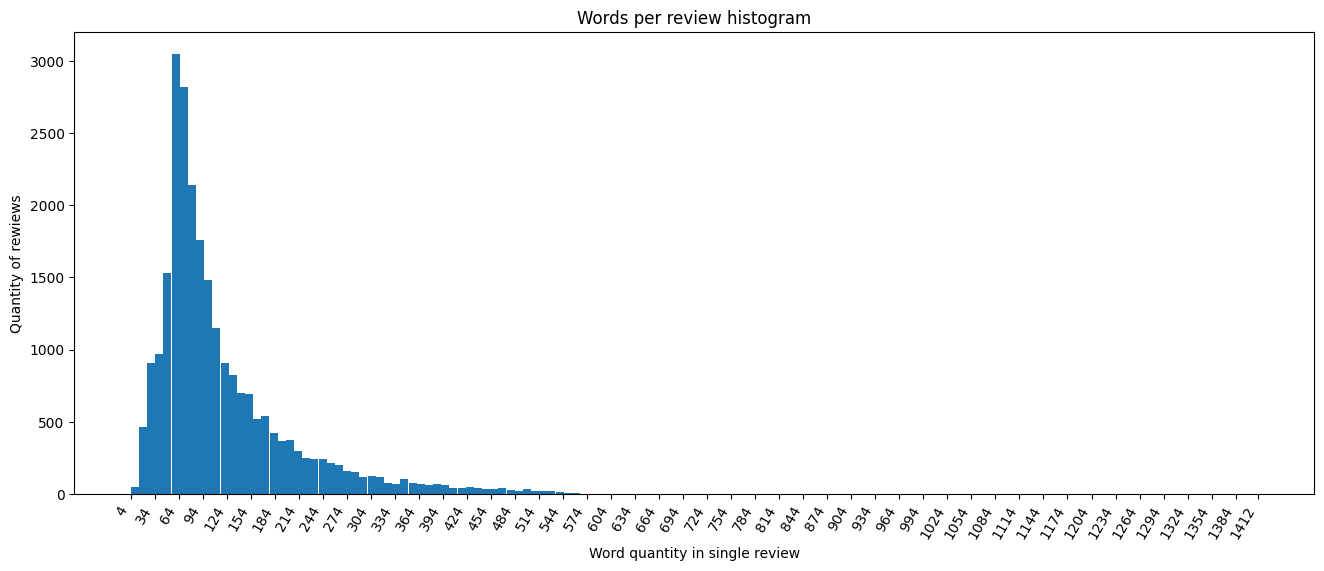

In [47]:
word_counts = sdv.make_count_histogram(reviews_train_binary, 30)


### Saving step 2 as a pickle

Because the data prepared in this step is ready for further processing it is saved as a picle as previously (end of step 1).

In [48]:
# Path to the file
output_file = "preprocessed_datasets/step_2/reviews_train_binary_step_2.pickle"

# save the corpus as a pickle
with open(output_file, 'wb') as f:
    pickle.dump(reviews_train_binary, f)

# step 3: Stemming and Lemmatization

Stemming is rather most common approach in the case of English language. Lemmatization is more common in inflected languages (such as Polish) where getting words to the root doesn't work very well. Corpus lemmatization also takes longer than stemming, so it is used less often for that reason.

So why am I also considering lemmatization instead of only stemming here? I would like to check whether the opinion I have come across is that the combination of these two methods can give good results. I came across this opinion in the literature [1]. I don’t know if it would be helpful also in the case of sentiment analysis (for English) and binary classification. It rather looks useful in more complex NLP problems. But I would like to check if maybe it will have a positive impact on sentiment analysis too. 

At the end of this subsection, 3 versions of the processed corpus will be saved:

- after stemming only
- after lemmatization only
- after lemmatization and stemming together

All these modifications are made using the function `lemm_stemm()`. It is defined for this purpose in the `supporting_modules/corpus_preprocessing` module.

### optional substep - Loading saved pickle

If you start this jupyter notebook from here, load the imports from the beginning section of the notebook and then run the cell below to get the preprocessed data:

In [49]:
# Load the data from pickle files

input_file = "preprocessed_datasets/step_2/reviews_train_binary_step_2.pickle"

with open(input_file, 'rb') as f:
    reviews_train_binary = pickle.load(f)

## Stemming

`PorterStemmer()` is one way to do stemming - one of the most popular but there are others.
Stemming in some cases, such as: "integral", "integration" will also bring them to the same stem - even though these are different words when analyzing texts consisting of thousands of words we accept that some small percentage will be collectively classified under the same core.

In [50]:
reviews_train_stemming = scp.lemm_stemm(reviews_train_binary)

In [51]:
reviews_train_stemming[0]

'dan katzir produc wonder film take us rollercoast ride real romanc set troubl surround modern israelfor anyon who ever love film bring back uncertainti insecur heartach make love bittersweet atmospher fear isol came difficult time israel time serv intensifi feel instantli drawn dan plight cant fail deepli movedy cant write drama passion like contrast realiti dan desper snatch relationship iri realiti state turmoil make emin watchabl ounc passion ever love see film'

## Lemmatization

Lemmatization is the process of mapping different forms of a word to a base word. This base word form is called lemma. Differently than stemming it does not cut the word to the shorter form but translates it into this lemma. For example "better" can be changed into "good" or "well" (it depends on the rule in the chosen Lemmatizer). In this project lemmatizer from `spacy` is applied (`spacy.load("en_core_web_sm")`)

In [52]:
reviews_train_lemmatization = scp.lemm_stemm(reviews_train_binary, stemming=False, lemmatization=True)

In [53]:
reviews_train_lemmatization[0]

'dan katzir produce wonderful film take we rollercoaster ride real romance set trouble surround modern israelfor anyone who s ever love film bring back uncertainty insecurity heartache make love bittersweet atmosphere fear isolation come difficult time israel time serve intensify feel instantly draw dan plight can not fail deeply movedyou can not write drama passion like contrast reality dan desperate snatch relationship iris realitie state turmoil make eminently watchable ounce passion ever love see film'

## Lemmatization + Stemming

In this case, both types of reducing a word to a simplified form I  applied. In the first step, the whole corpus is lemmatized and then all words are stemmed. I would like to check if this addition will affect the prediction results and how. Of course, such an approach not always is good in real life because of efficiency reasons. 

In [54]:
reviews_train_lemma_stemm = scp.lemm_stemm(reviews_train_lemmatization, stemming=True)

In [55]:
reviews_train_lemma_stemm[0]

'dan katzir produc wonder film take we rollercoast ride real romanc set troubl surround modern israelfor anyon who s ever love film bring back uncertainti insecur heartach make love bittersweet atmospher fear isol come difficult time israel time serv intensifi feel instantli draw dan plight can not fail deepli movedy can not write drama passion like contrast realiti dan desper snatch relationship iri realiti state turmoil make emin watchabl ounc passion ever love see film'


### Saving step 3 as a pickle

Data transformations from this point took a long time. Lemmatization lasted the longest, which was expected. Stemming works faster and in cases where short data preparation time is important, it will be a natural choice.

In order to be able to quickly reconstruct the results of this stage, as before, the current status of data processing was made in the pickle format. It is particularly important to save data after lemmatization.

In [56]:
# Path to the file
output_file = "preprocessed_datasets/step_3/reviews_train_lemmatization_step_3.pickle"

# save the corpus as a pickle
with open(output_file, 'wb') as f:
    pickle.dump(reviews_train_lemmatization, f)

output_file = "preprocessed_datasets/step_3/reviews_train_stemming_step_3.pickle"

with open(output_file, 'wb') as f:
    pickle.dump(reviews_train_stemming, f)

output_file = "preprocessed_datasets/step_3/reviews_train_lemma_stemm_step_3.pickle"

with open(output_file, 'wb') as f:
    pickle.dump(reviews_train_lemma_stemm, f)

# step 4: Conversion text data into vectors

The next step after cleaning the data is to transform the data into a matrix.  Machine learning models, such as classification or regression models, operate on numerical data. Transforming text into a matrix allows you to replace abstract strings of words with specific numbers that can be processed by models.

Transforming text into a matrix allows to creation of feature vectors, where each feature corresponds to a certain aspect of the text. For example, each column in the matrix represents a specific word or group of words (n-grams).

### optional substep - Loading saved pickles

If you start this jupyter notebook from here, load the imports from the beginning section of the notebook and then run the cell below to get the preprocessed data:

In [3]:
# Load the data from pickle files

input_file = "preprocessed_datasets/step_3/reviews_train_stemming_step_3.pickle"
with open(input_file, 'rb') as f:
    reviews_train_stemming_step_4 = pickle.load(f)

input_file = "preprocessed_datasets/step_3/reviews_train_lemmatization_step_3.pickle"
with open(input_file, 'rb') as f:
    reviews_train_lemmatization_step_4 = pickle.load(f)

input_file = "preprocessed_datasets/step_3/reviews_train_lemma_stemm_step_3.pickle"
with open(input_file, 'rb') as f:
    reviews_train_lemma_stemm_step_4 = pickle.load(f)

# Load test dataset and labels connected with. They were saved at the end of 1st step

input_file = "preprocessed_datasets/step_1/reviews_test.pickle"
with open(input_file, 'rb') as f:
    reviews_test = pickle.load(f)

input_file = "preprocessed_datasets/step_1/y_test.pickle"
with open(input_file, 'rb') as f:
    y_test = pickle.load(f)

input_file = "preprocessed_datasets/step_1/y_train_binary.pickle"
with open(input_file, 'rb') as f:
    y_train_binary = pickle.load(f)

## 4.0 Test data preprocessing

Because data preprocessing will look the same for all models these activities will be performed at this step (4). The cleaning data and preprocessing are part of the common initial activities on test data it makes no sense to launch the same functions for the same data for each substep. Suppose this step is taken in each set for each model. For simplicity, it is made once in the cell below and used to transfer to the model to check the classification.

Preprocessing is conducted using methods defined after the current step and the previous one. Both are defined in `supporting_modules/corpus_preprocessing`. Below run for testing purposes. 

In [58]:
# test the corpus preprocessing functions

reviews_test_test = scp.text_data_cleanup(reviews_test, get_info=True)

reviews_test_test = scp.preprocess_corpus(reviews_test_test)

re.compile('<+ ')

REMOVED SUBSTRINGS SAMPLE:
 ['<< ', '<<<<< ', '< ']

11 elements removed
re.compile('<[^>]+>')

REMOVED SUBSTRINGS SAMPLE:
 ['</i>', '<grin>', '<i>', '<<<<<<br />', '<-----minor spoilers!---->', '<br />', '<33<br />', '<p>', '<<<<<br />', '<-----minor spoilers!----->']

100085 elements removed
re.compile('\\S*@\\S*(?=[\\s.!?,]|$)')

REMOVED SUBSTRINGS SAMPLE:
 ['kk2840@earthlink.net', 'shawe49@aol.com', '@$$.', 'fu#@ing', 'cr@pfest.', 'valid908@yahoo.com', '$%#@#$.', 'hpn_x@hotmail.com', 'f@rt,@ss,', 'cr@ppy']

92 elements removed
re.compile('(http[s]?://|www[.])(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\\\(\\\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')

REMOVED SUBSTRINGS SAMPLE:
 ['http://', 'www.']

103 elements removed
re.compile('\\d+')

REMOVED SUBSTRINGS SAMPLE:
 ['1939', '2700', '83', '517', '1845', '1977', '1604', '4000', '3', '747']

38484 elements removed
Applied pattern => \b(?:don't|aren't|couldn't|didn't|doesn't|hadn't|hasn't|haven't|isn't|mightn't|mustn't|needn't|shan'

## 4.1 Bag of words

Bag of words (BoW) is a very common approach in the case of large collections of text data in NLP. In this technique, the "bag" is an unordered bunch of words, the frequency and similarity of words in the document are compared there. If two documents include a similar set of words - then they belong to the same class according to this approach. 
The implementation of BoW is for example CountVectorizer. It is a transformer that includes the fit() and transform() methods. In fit(), texts are tokenized - a list of unique words is created along with the number of occurrences.

In this substep the text data in two variants (after stemming and after stemming+lemmatization will be checked). I would like to check whether this approach actually gives better results and whether the differences are actually significant.

### 4.1.1 CountVectorizer, Naive Bayes, Stemming

CountVectorizer is one of the basic text vectorization tools that represent text by counting the occurrences of words. For each document in the corpus, it creates a vector where each entry corresponds to a word, and the value is the number of occurrences of that word in the document.

CountVectorizer does not take into account information about the frequency of words in the corpus, which can lead to a low weight for words that appear frequently in texts (e.g. stopwords and other frequent words without important meaning) and a high weight for rare words. More advanced techniques such as TF-IDF can be used to take into account the meaning of words. TF-IDF will be applied in the next steps...

Before training let's try to find what values of picked parameters would be the best. I decided to use RandomizedSearch for this for time efficiency reasons. In a situation where we have an unlimited amount of time, GridSearch can help us choose more accurate parameters but it requires more experiments with the discrete feature values.  

By checking a single model, the Pipeline preparation process for further training and prediction may look like below. However, because in this case, it will be a repeatable action for each sub-step - that's why an additional function has been created that will return Pipeline with parameters recognized by `RandomizedSearchCV` as the best of the checked ones. 

The mentioned function is `get_pipeline_with_best_params()` and it is defined in the module `supporting_modules/models_preparation`. 

In [4]:
# random selection of a list of features and parameters

param_dist = {
    "vectorizer__max_features": [1000, 2000, 3000], 
    "model__alpha": uniform(0.1, 2.0) 
}

# Pipeline
pipeline = Pipeline([
    ("vectorizer", CountVectorizer()), 
    ("model", MultinomialNB())
])

# RandomizedSearchCV with parameter sampling
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=10, cv=5, scoring="accuracy")
random_search.fit(reviews_train_stemming_step_4, y_train_binary)

best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best parameters:", best_params)
print("best score:", best_score)


Best parameters: {'model__alpha': 0.18798686557210656, 'vectorizer__max_features': 3000}
best score: 0.8384997367506566


Only in this subpoing the data parameter values are set manualy using `best_params` values returned from `RandomizedSearchCV`. 

In [5]:
# Pipeline
pipeline = Pipeline([
    ("vectorizer", CountVectorizer(max_features=best_params['vectorizer__max_features'])), 
    ("model", MultinomialNB(alpha=best_params['model__alpha']))
])

In [6]:
pipeline.fit(reviews_train_stemming_step_4, y_train_binary)

Pipeline(steps=[('vectorizer', CountVectorizer(max_features=3000)),
                ('model', MultinomialNB(alpha=0.18798686557210656))])

### Test data preprocessing - stemming

Further data preprocessing - stemming is applied on test data using the function `supporting_modules/corpus_preprocessing/lemm_stemm()` as in training data with which the model will compare during prediction. 

In [62]:
reviews_test_stemming = scp.lemm_stemm(reviews_test_test)

#### Save preprocessed data after stemming as a pickle

For easier use of data in further steps. In order not to duplicate the same actions that were performed once - here. It will be used in subsections but the pre-processing method is the same. Therefore, the data was saved as a pickle at the end.

In [64]:
# Path to the file
output_file = "preprocessed_datasets/step_4/reviews_test_preprocessed_stemm.pickle"

# save the corpus as a pickle
with open(output_file, 'wb') as f:
    pickle.dump(reviews_test_stemming, f)

### Test data prediction and model evaluation

To change the amount of repetitive code (which would look the same for each subsection), the `evaluate_model()` function defined in the `supporting_modules/models_preparation` module was added.

The function launches `predict(X_test)` method on the passed model or pipeline. Then it conducts evaluation and returns metrics as DataFrame and displays additional plots: ROC curve and Confusion matrix.

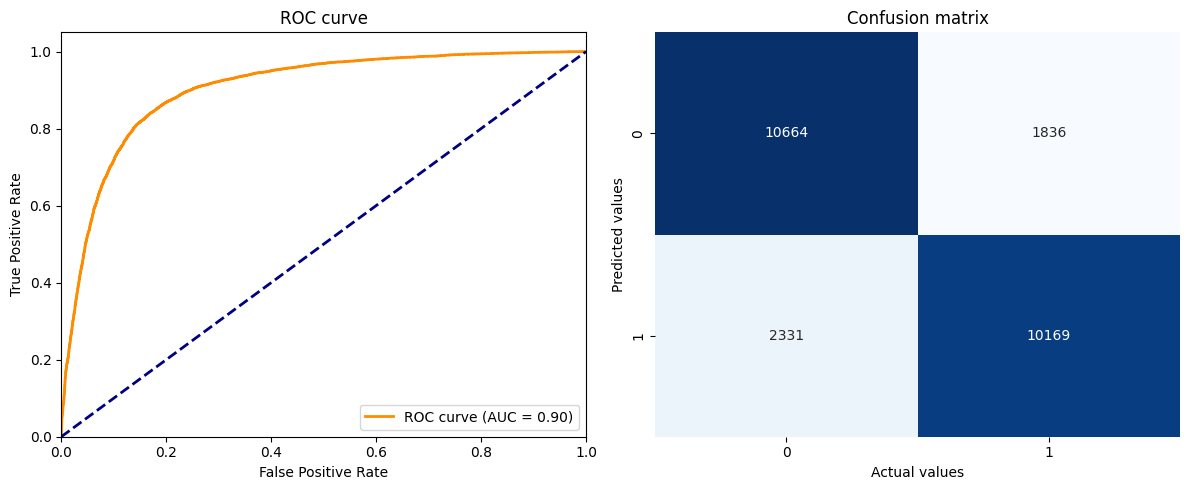

,Metric,Metric value
0,accuracy,0.833320
1,precision,0.847064
2,recall,0.813520
3,F1 Score,0.829953
4,ROC AUC,0.902492


In [7]:
smp.evaluate_model(pipeline, reviews_test_stemming, y_test)

The metrics look quite promising, considering they were returned for a bag of single words, simple vectorization, and the use of the NaiveBayes model which is the simplest model used in the current project.

The model correctly classified approximately 83.3% of the samples (accuracy), and approximately 84.7% of the model's positive classifications were true positives. ROC AUC is approximately 0.902. This is a measure of the quality of a classification model that evaluates the model's ability to distinguish between classes. A higher ROC AUC value indicates a better model. So it looks like not a bad starting point.

### 4.1.2 CountVectorizer, Naive Bayes, Stemming + Lemmatization

As in the previous subpoint, the search for the best parameters is conducted here. The same steps will be performed to find good parameters for vectorization and model. This time, a function created for this purpose will be used: `supporting_modules/models_preparation/get_pipeline_with_best_params()`. 
The returned pipeline is used to train the model and predict the labels from the test dataset.

The purpose of the function is to choose good parameters for the pipeline and return a pilepine with these parameters. RadnomizedSearch is used inside for sampling. It is an approach that randomly selects combinations of parameters to test rather than testing all possible combinations. This is especially useful when the parameter space is large and testing each combination is time-consuming.

As written earlier: for each check of the model's operation for cleaned and with stemming applied to data, an analogic step will be performed to check what would be the effect of adding additional processing in the form of lemmatization before stemming.

In [8]:
# random selection of a list of features and parameters

param_dist = {
    "vectorizer__max_features": [1000, 2000, 3000], 
    "model__alpha": uniform(0.1, 2.0) 
}

In [9]:
pipeline = smp.get_pipeline_with_best_params(corpus=reviews_train_lemma_stemm_step_4, labels=y_train_binary,
                                             vectorizer=CountVectorizer(), model=MultinomialNB(), 
                                             param_distributions=param_dist)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'model__alpha': 0.5632567950165422, 'vectorizer__max_features': 3000}

best score: 0.837014018733033


In [10]:
pipeline.fit(reviews_train_lemma_stemm_step_4, y_train_binary)

Pipeline(steps=[('vectorizer', CountVectorizer(max_features=3000)),
                ('model', MultinomialNB(alpha=0.5632567950165422))])

### Test data preprocessing - lemmatization + stemming

Further data preprocessing - lemmatization and stemming together are applied on test data using the function `supporting_modules/corpus_preprocessing/lemm_stemm()` as in training data with which the model will compare during prediction. 

In [69]:
reviews_test_lemma_stemm = scp.lemm_stemm(reviews_test_test, lemmatization=True, stemming=True)

### Save preprocessed data after lemmatization and stemming as a pickle

Analogically as in the case of stemming on test data - in order not to duplicate the same actions that were performed once the preprocessed test data are saved as a pickle for easy use whenever it is needed in further steps. 

In [70]:
# Path to the file
output_file = "preprocessed_datasets/step_4/reviews_test_preprocessed_lemm_stemm.pickle"

# save the corpus as a pickle
with open(output_file, 'wb') as f:
    pickle.dump(reviews_test_lemma_stemm, f)

### Test data prediction and model evaluation

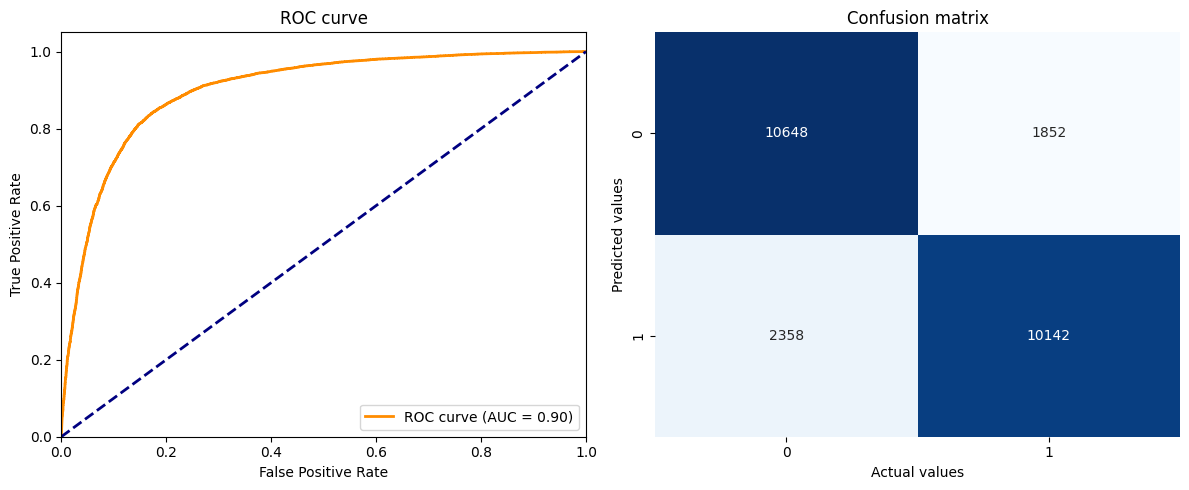

,Metric,Metric value
0,accuracy,0.831600
1,precision,0.845589
2,recall,0.811360
3,F1 Score,0.828121
4,ROC AUC,0.900638


In [11]:
smp.evaluate_model(pipeline, reviews_test_lemma_stemm, y_test)

Comparing these results, it can be seen that the differences between the two models are small. Both models achieved similar results in terms of accuracy, precision, sensitivity, F1 Score, and ROC AUC.

For now, it looks like additional lemmatization has no effect on the problem under study in this model and type of vectorization.

### 4.1.3 CountVectorizer, Logistic Regression, Stemming

I chose Logistic Regression as the second model checked. A sentiment analysis problem is typically a binary classification task where we try to predict whether a given text is positive or negative. Logistic regression seems to be a nice choice for such tasks and can provide good comparative results. It is relatively computationally efficient, which means it can be applied to large data sets.

The selection of parameters, training the model and checking the metrics will be performed in the same way as in the previous steps of this section.

In [12]:
param_dist = {
    "vectorizer__max_features": [1000, 2000, 3000], 
    "model__C": uniform(0.1, 2.0),  # Random selection of regularization parameter
    "model__penalty": ["l1", "l2"],  # type of regularization
    "model__solver": ['liblinear'], # I had to change the default solver because of a warning:
                                # ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty".
    "model__max_iter": [500]
}

In [13]:
pipeline = smp.get_pipeline_with_best_params(corpus=reviews_train_stemming_step_4, labels=y_train_binary,
                                             vectorizer=CountVectorizer(), model=LogisticRegression(), 
                                             param_distributions=param_dist)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'model__C': 0.17179793396398826, 'model__max_iter': 500, 'model__penalty': 'l1', 'model__solver': 'liblinear', 'vectorizer__max_features': 2000}

best score: 0.8632347821319406


### Training model and prediction on the test dataset

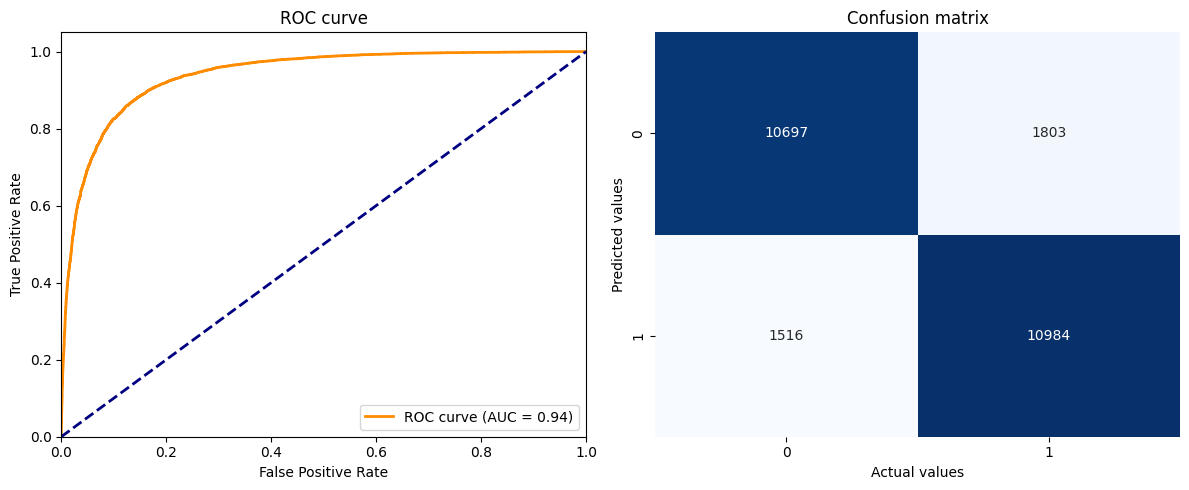

,Metric,Metric value
0,accuracy,0.867240
1,precision,0.858997
2,recall,0.878720
3,F1 Score,0.868747
4,ROC AUC,0.938623


In [14]:
pipeline.fit(reviews_train_stemming_step_4, y_train_binary)

# test data prediction
y_pred = pipeline.predict(reviews_test_stemming)


smp.evaluate_model(pipeline, reviews_test_stemming, y_test)

### 4.1.4 CountVectorizer, Logistic Regression, Stemming + Lemmatization

As was the case with NaiveBayes, a similar training will be carried out as in the previous section, but for data that has been subjected to Lemmatization and Stemming. It will be checked again whether such a change brings anything positive to the problem under consideration.

In [15]:
param_dist = {
    "vectorizer__max_features": [1000, 2000, 3000], 
    "model__C": uniform(0.1, 2.0),  # Random selection of regularization parameter
    "model__penalty": ["l1", "l2"],  # type of regularization
    "model__solver": ['liblinear'], # I had to change the default solver because of a warning:
                                # ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty".
    "model__max_iter": [500]
}

pipeline = smp.get_pipeline_with_best_params(corpus=reviews_train_lemma_stemm_step_4, labels=y_train_binary,
                                             vectorizer=CountVectorizer(), model=LogisticRegression(), 
                                             param_distributions=param_dist)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'model__C': 0.34425786237847145, 'model__max_iter': 500, 'model__penalty': 'l1', 'model__solver': 'liblinear', 'vectorizer__max_features': 3000}

best score: 0.8657645559148863


### Model training

In [16]:
pipeline.fit(reviews_train_lemma_stemm_step_4, y_train_binary)

Pipeline(steps=[('vectorizer', CountVectorizer(max_features=3000)),
                ('model',
                 LogisticRegression(C=0.34425786237847145, max_iter=500,
                                    penalty='l1', solver='liblinear'))])

### Prediction on the test dataset

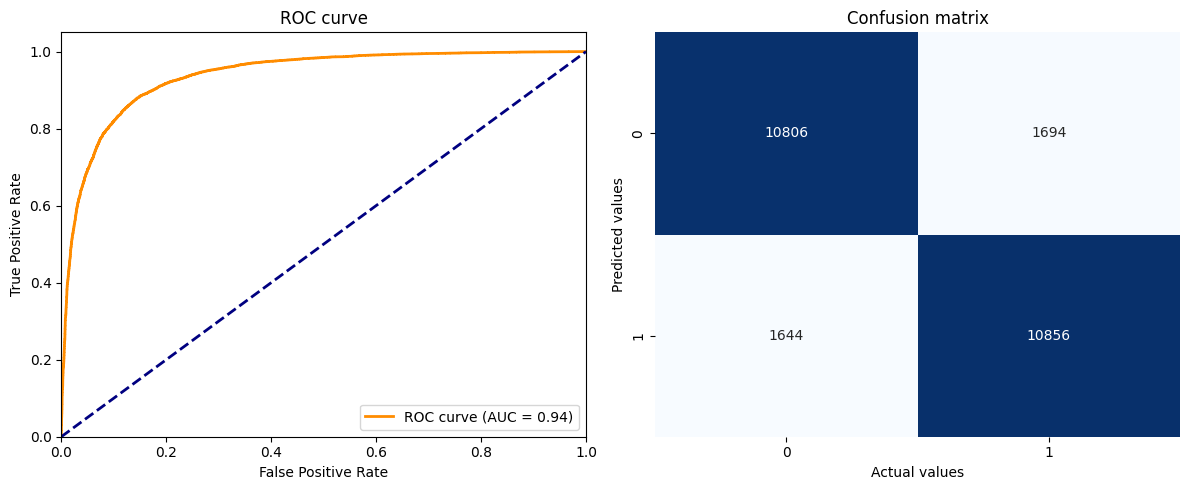

,Metric,Metric value
0,accuracy,0.866480
1,precision,0.865020
2,recall,0.868480
3,F1 Score,0.866747
4,ROC AUC,0.936979


In [17]:
# test data prediction
y_pred = pipeline.predict(reviews_test_lemma_stemm)


smp.evaluate_model(pipeline, reviews_test_lemma_stemm, y_test)

After processing the data, Logistic Regression models seem to perform better compared to the other two models (Naive Bayes) in each of the metrics. This is a promising result. 

However, it is also visible that in this case (comparing 4.1.3 and 4.1.4), adding an additional step in the form of lemmatization does not significantly improve the effectiveness of the forecasts themselves. Both models seem to achieve very similar results in terms of accuracy, precision, sensitivity, F1 Score and ROC AUC. The differences between the two are small, and neither model appears to significantly outperform the other in any of these metrics.

### 4.1.5 CountVectorizer, SVC, Stemming

I chose Support Vector Machine (SVC) for sentiment analysis because it can be a good binary classification tool, which is often sufficient in a sentiment analysis task where we want to classify texts as positive or negative. It is able to handle data with a large number of features, which can be beneficial in text analysis.

The steps performed in the following two subsections (4.1.5, 4.1.6) are analogous to those in the previous 4 subsections (Naive Bayes and Logistic Regression).

In [4]:
param_dist = {
    "vectorizer__max_features": [2000, 3000], 
    "model__C": uniform(0.1, 2.0),  # Random selection of regularization parameter
    "model__kernel": ["linear", "rbf", "sigmoid"],  # Selection of the type of kernel 
    "model__probability": [True]
}

pipeline = smp.get_pipeline_with_best_params(corpus=reviews_train_stemming_step_4, labels=y_train_binary,
                                             vectorizer=CountVectorizer(), model=SVC(), 
                                             param_distributions=param_dist, cv=3)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'model__C': 1.1049110457839764, 'model__kernel': 'rbf', 'model__probability': True, 'vectorizer__max_features': 3000}

best score: 0.8608657432805075


In [20]:
pipeline.fit(reviews_train_stemming_step_4, y_train_binary)


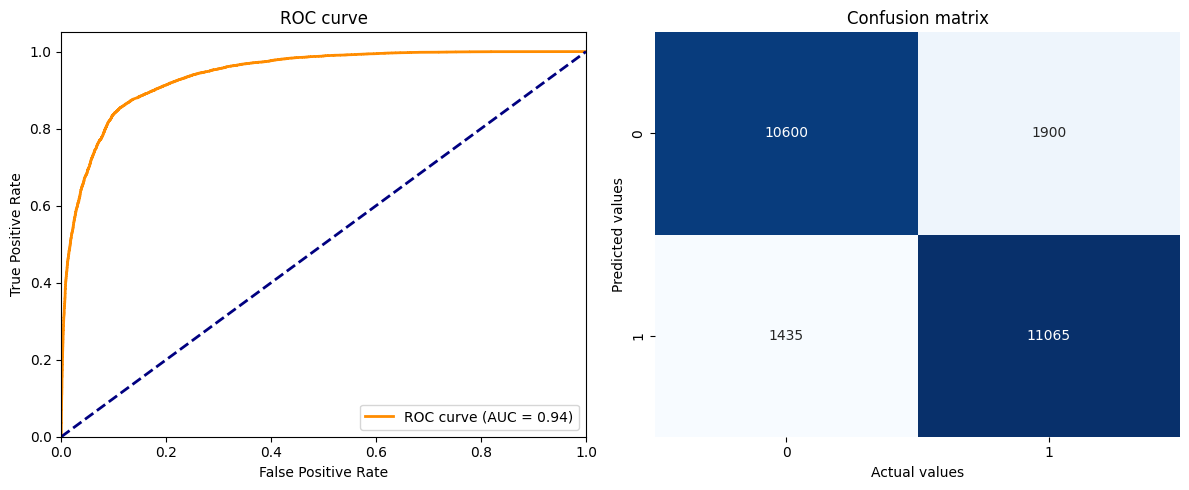

,Metric,Metric value
0,accuracy,0.866600
1,precision,0.853452
2,recall,0.885200
3,F1 Score,0.869036
4,ROC AUC,0.940550


In [19]:
smp.evaluate_model(pipeline, reviews_test_stemming, y_test)

### 4.1.6 CountVectorizer, SVC, Lemmatization + Stemming

The disadvantage of using RandomizedSearchCV with cross-validation to check many features is that searching for optimal parameters takes a very long time. In my case, it was several hours for a function with default parameters.

In the following points, I passed to the pipelines with SVC the parameters of the calculated assumptions of these two points.

In [7]:
from sklearn.svm import SVC

param_dist = {
    "vectorizer__max_features": [2000, 3000], 
    "model__C": uniform(0.1, 2.0),  # Random selection of regularization parameter
    "model__kernel": ["linear", "rbf", "sigmoid"],  # Selection of the type of kernel
    "model__probability": [True]
}

pipeline = smp.get_pipeline_with_best_params(corpus=reviews_train_lemma_stemm_step_4, labels=y_train_binary,
                                             vectorizer=CountVectorizer(), model=SVC(), 
                                             param_distributions=param_dist, cv=3)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'model__C': 1.5548268721320542, 'model__kernel': 'rbf', 'model__probability': True, 'vectorizer__max_features': 3000}

best score: 0.862712813550834


In [21]:
pipeline.fit(reviews_train_lemma_stemm_step_4, y_train_binary)

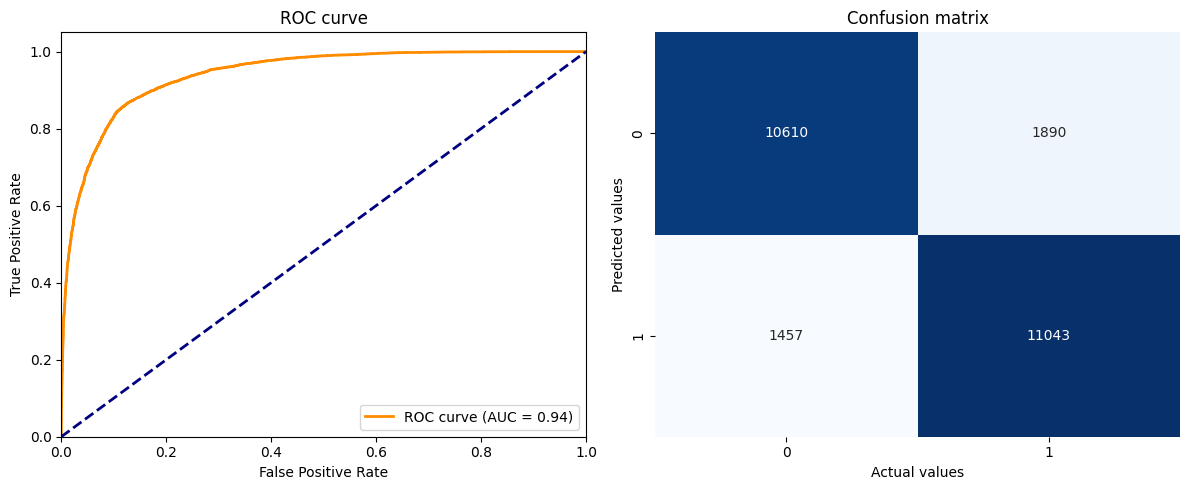

,Metric,Metric value
0,accuracy,0.866120
1,precision,0.853862
2,recall,0.883440
3,F1 Score,0.868399
4,ROC AUC,0.940293


In [23]:
# test data prediction and evaluation
smp.evaluate_model(pipeline, reviews_test_lemma_stemm, y_test)

## Conclusion for 4.1

Comparing the metrics values in the three tested models, we can see an increase in the improvement of each of the tested models. The parameters of individual metrics are better in each subsequent model used.

At the same time, for the sets of transformations used here, there are no significant differences between the corpus subjected to Stemming and the one for which lemmatization was additionally applied.

---------------------------------------------------------------------------------------------------------------

## 4.2 Bag of n-grams

At this point, analogous variants are checked as before, except that we expand the set to n-grams. As it turned out when checking the parameters. In this case, bi-grams gave the best results, so I will rely on them in further models.

Using 2-grams seems good because detecting phrases such as "not" is important in sentiment analysis because it can reverse the meaning of the sentiment in a sentence.

Bi-grams allow you to take context into account, which can help you understand the meaning of a sentence more precisely. For example, the sentence "not bad" is positive, but without taking bi-grams into account, it can be treated as negative. 2-grams help detect expressions related to negations, which often change the meaning of the sentiment. 

Of course, this significantly increases the dimensionality of the data and may lead to greater model complexity.

### 4.2.1 CountVectorizer, Naive Bayes, Stemming, bigrams

In [8]:
param_dist = {
    "vectorizer__max_features": [1000, 2000, 3000], 
    "vectorizer__ngram_range": [(1, 2), (1, 3)], 
    "model__alpha": uniform(0.1, 2.0) 
}

In [9]:
pipeline = smp.get_pipeline_with_best_params(corpus=reviews_train_stemming_step_4, labels=y_train_binary,
                                             vectorizer=CountVectorizer(), model=MultinomialNB(), 
                                             param_distributions=param_dist)

Best parameters: {'model__alpha': 1.1414535295019215, 'vectorizer__max_features': 3000, 'vectorizer__ngram_range': (1, 2)}

best score: 0.840186120914092


In [10]:
pipeline.fit(reviews_train_stemming_step_4, y_train_binary)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_features=3000, ngram_range=(1, 2))),
                ('model', MultinomialNB(alpha=1.1414535295019215))])

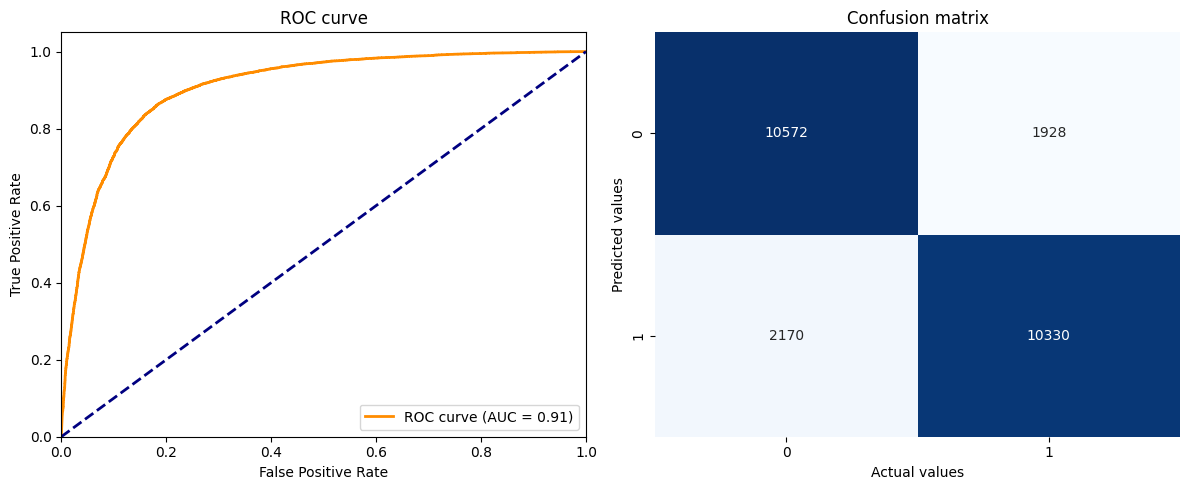

,Metric,Metric value
0,accuracy,0.836080
1,precision,0.842715
2,recall,0.826400
3,F1 Score,0.834478
4,ROC AUC,0.906539


In [25]:
smp.evaluate_model(pipeline, reviews_test_stemming, y_test)

### 4.2.2 CountVectorizer, Naive Bayes, Stemming + Lemmatization, bigrams

In [4]:
param_dist = {
    "vectorizer__max_features": [1000, 2000, 3000], 
    "vectorizer__ngram_range": [(1, 2), (1, 3)], 
    "model__alpha": uniform(0.1, 2.0) 
}

In [5]:
pipeline = smp.get_pipeline_with_best_params(corpus=reviews_train_lemma_stemm_step_4, labels=y_train_binary,
                                             vectorizer=CountVectorizer(), model=MultinomialNB(), 
                                             param_distributions=param_dist)

Best parameters: {'model__alpha': 2.0496907301241207, 'vectorizer__max_features': 3000, 'vectorizer__ngram_range': (1, 2)}

best score: 0.837054098747933


In [6]:
pipeline.fit(reviews_train_lemma_stemm_step_4, y_train_binary)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_features=3000, ngram_range=(1, 2))),
                ('model', MultinomialNB(alpha=2.0496907301241207))])

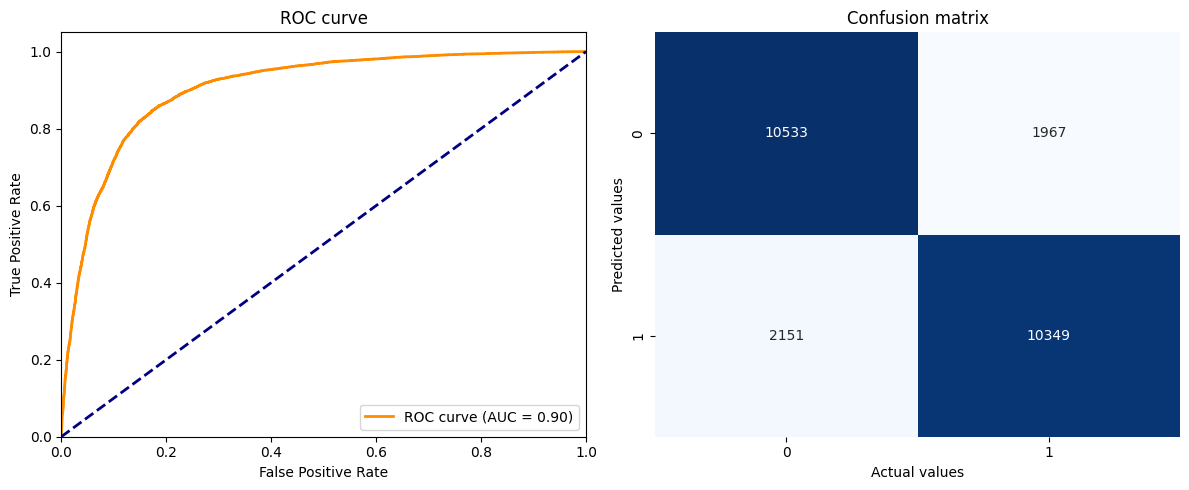

,Metric,Metric value
0,accuracy,0.835280
1,precision,0.840289
2,recall,0.827920
3,F1 Score,0.834059
4,ROC AUC,0.904287


In [27]:
smp.evaluate_model(pipeline, reviews_test_lemma_stemm, y_test)

### 4.2.3 CountVectorizer, Logistic Regression, Stemming, bigrams

In [11]:
param_dist = {
    "vectorizer__max_features": [1000, 2000, 3000], 
    "vectorizer__ngram_range": [(1, 2), (1, 3)], 
    "model__C": uniform(0.1, 2.0),  # Random selection of regularization parameter
    "model__penalty": ["l1", "l2"],  # type of regularization
    "model__solver": ['liblinear'], # I had to change the default solver because of a warning:
                                # ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty".
    "model__max_iter": [500]
}

In [12]:
pipeline = smp.get_pipeline_with_best_params(corpus=reviews_train_stemming_step_4, labels=y_train_binary,
                                             vectorizer=CountVectorizer(), model=LogisticRegression(), 
                                             param_distributions=param_dist)                                             

Best parameters: {'model__C': 0.15645312985644147, 'model__max_iter': 500, 'model__penalty': 'l2', 'model__solver': 'liblinear', 'vectorizer__max_features': 2000, 'vectorizer__ngram_range': (1, 3)}

best score: 0.8580548574543103


In [29]:
pipeline.fit(reviews_train_stemming_step_4, y_train_binary)

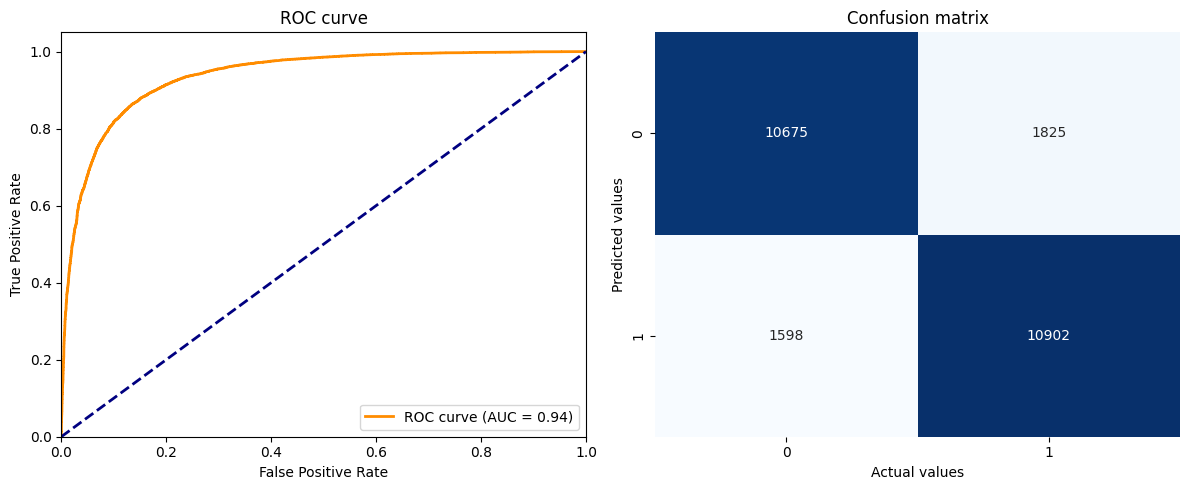

,Metric,Metric value
0,accuracy,0.863080
1,precision,0.856604
2,recall,0.872160
3,F1 Score,0.864312
4,ROC AUC,0.935845


In [31]:
smp.evaluate_model(pipeline, reviews_test_stemming, y_test)

### 4.2.4 CountVectorizer, Logistic Regression, Stemming + Lemmatization, bigrams

In [15]:
param_dist = {
    "vectorizer__max_features": [1000, 2000, 3000], 
    "vectorizer__ngram_range": [(1, 2), (1, 3)],
    "model__C": uniform(0.1, 2.0),  # Random selection of regularization parameter
    "model__penalty": ["l1", "l2"],  # type of regularization
    "model__solver": ['liblinear'], # I had to change the default solver because of a warning:
                                # ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty".
    "model__max_iter": [500]
}

pipeline = smp.get_pipeline_with_best_params(corpus=reviews_train_lemma_stemm_step_4, labels=y_train_binary,
                                             vectorizer=CountVectorizer(), model=LogisticRegression(), 
                                             param_distributions=param_dist)                                


Best parameters: {'model__C': 1.1250987068783858, 'model__max_iter': 500, 'model__penalty': 'l1', 'model__solver': 'liblinear', 'vectorizer__max_features': 2000, 'vectorizer__ngram_range': (1, 2)}

best score: 0.8559670845598818


In [32]:
pipeline.fit(reviews_train_lemma_stemm_step_4, y_train_binary)

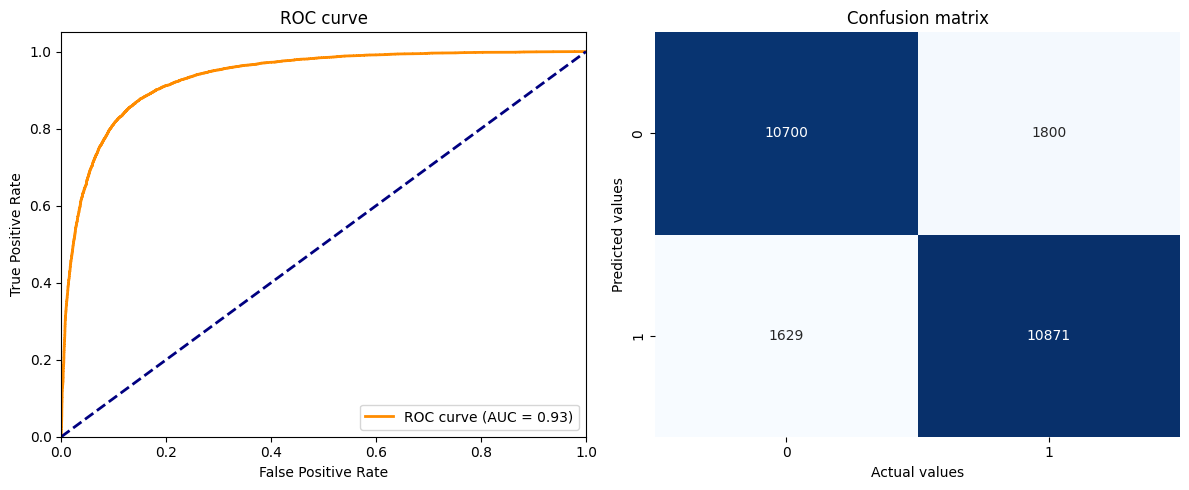

,Metric,Metric value
0,accuracy,0.862840
1,precision,0.857943
2,recall,0.869680
3,F1 Score,0.863772
4,ROC AUC,0.933804


In [35]:
smp.evaluate_model(pipeline, reviews_test_lemma_stemm, y_test)

### 4.2.5 CountVectorizer, SVC, Stemming, bigrams

In [ ]:
param_dist = {
    "vectorizer__max_features": [2000, 3000], 
    "vectorizer__ngram_range": [(1, 2)], 
    "model__C": uniform(0.1, 2.0),  # Random selection of regularization parameter
    "model__kernel": ["linear", "rbf", "sigmoid"],  # Selection of the type of kernel 
    "model__probability": [True]
}

pipeline = smp.get_pipeline_with_best_params(corpus=reviews_train_stemming_step_4, labels=y_train_binary,
                                             vectorizer=CountVectorizer(), model=SVC(), 
                                             param_distributions=param_dist, cv=3)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [5]:
# pipeline = Pipeline([
#     ("vectorizer", CountVectorizer(max_features=3000, 
#                                   ngram_range=(1, 2))), 
#     ("model", SVC(C=1.1049110457839764, kernel="rbf", probability=True))
# ])

In [6]:
pipeline.fit(reviews_train_stemming_step_4, y_train_binary)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_features=3000, ngram_range=(1, 2))),
                ('model', SVC(C=1.1049110457839764, probability=True))])

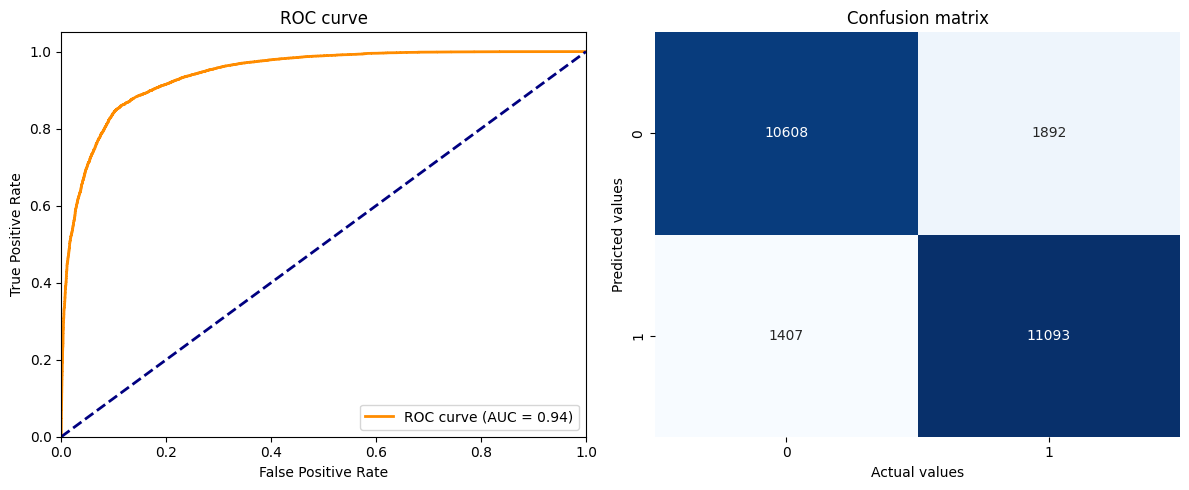

,Metric,Metric value
0,accuracy,0.868040
1,precision,0.854293
2,recall,0.887440
3,F1 Score,0.870551
4,ROC AUC,0.942154


In [7]:
smp.evaluate_model(pipeline, reviews_test_stemming, y_test)

## Conclusion for 4.2

Comparing CountVectorizer and the same models with the default value ngram_range" = (1, 1) in the case of a bag of words and changing only to bi-grams without changing the vectorizer, there are practically no differences between the results obtained. The only thing that was different was the much longer training time of each model in section 4.2. 

## 4.3 TF-IDF

TFIDF (TF – term frequency, IDF – inverse document frequency) informs about the frequency of occurrence of terms while taking into account the appropriate balance between the meaning of the local term and its meaning in the context of the full document collection.

Words specific to a given document are searched for - a word that is important for a given document appears frequently in the document but at the same time appears rarely in the corpus (the entire set of documents). It allows us to go beyond just checking word frequency, the algorithm is based on how important a given word is for a given document. The TF-IDF transform measures how important individual words are in individual documents.

Tf = term frequency - word frequency in the document.

Idf - inverse document frequency - the inverse of the word frequency in the set of documents.

### 4.3.1 TfidfVectorizer, Naive Bayes, Stemming, bigrams

In [34]:
param_dist = {
    "vectorizer__max_df": [0.9],
    "vectorizer__min_df": uniform(0.001, 0.01),    
    "vectorizer__ngram_range": [(1, 2)], 
    "model__alpha": uniform(0.1, 2.0) 
}

In [35]:
pipeline = smp.get_pipeline_with_best_params(corpus=reviews_train_stemming_step_4, labels=y_train_binary,
                                             vectorizer=TfidfVectorizer(), model=MultinomialNB(), 
                                             param_distributions=param_dist, n_iter=10, cv=5)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'model__alpha': 1.6209112766922293, 'vectorizer__max_df': 0.9, 'vectorizer__min_df': 0.002151435129442817, 'vectorizer__ngram_range': (1, 2)}

best score: 0.856408335611065


In [36]:
pipeline.fit(reviews_train_stemming_step_4, y_train_binary)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.9, min_df=0.002151435129442817,
                                 ngram_range=(1, 2))),
                ('model', MultinomialNB(alpha=1.6209112766922293))])

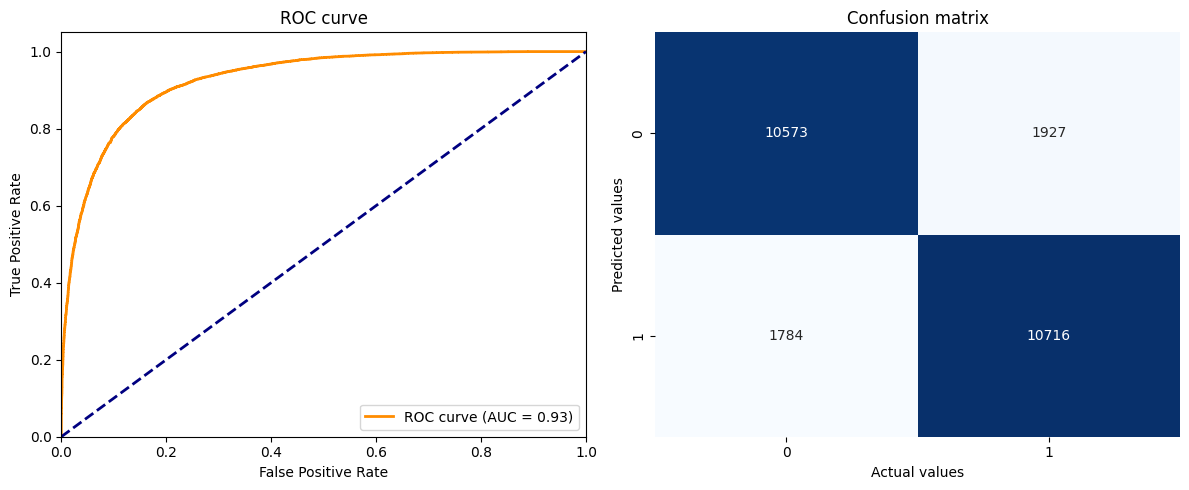

,Metryka,Wartość
0,accuracy,0.851560
1,precision,0.847584
2,recall,0.857280
3,F1 Score,0.852404
4,ROC AUC,0.927081


In [37]:
smp.evaluate_model(pipeline, reviews_test_stemming, y_test)

### 4.3.2 TfidfVectorizer, Naive Bayes, Stemming + Lemmatization, bigrams

In [41]:
param_dist = {
    "vectorizer__max_df": [0.9],
    "vectorizer__min_df": uniform(0.001, 0.01),    
    "vectorizer__ngram_range": [(1, 2)], 
    "model__alpha": uniform(0.1, 2.0) 
}

In [42]:
pipeline = smp.get_pipeline_with_best_params(corpus=reviews_train_lemma_stemm_step_4, labels=y_train_binary,
                                             vectorizer=TfidfVectorizer(), model=MultinomialNB(), 
                                             param_distributions=param_dist)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'model__alpha': 0.7231096043527946, 'vectorizer__max_df': 0.9, 'vectorizer__min_df': 0.0016521385496845523, 'vectorizer__ngram_range': (1, 2)}

best score: 0.8585364465289385


In [43]:
pipeline.fit(reviews_train_lemma_stemm_step_4, y_train_binary)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.9, min_df=0.0016521385496845523,
                                 ngram_range=(1, 2))),
                ('model', MultinomialNB(alpha=0.7231096043527946))])

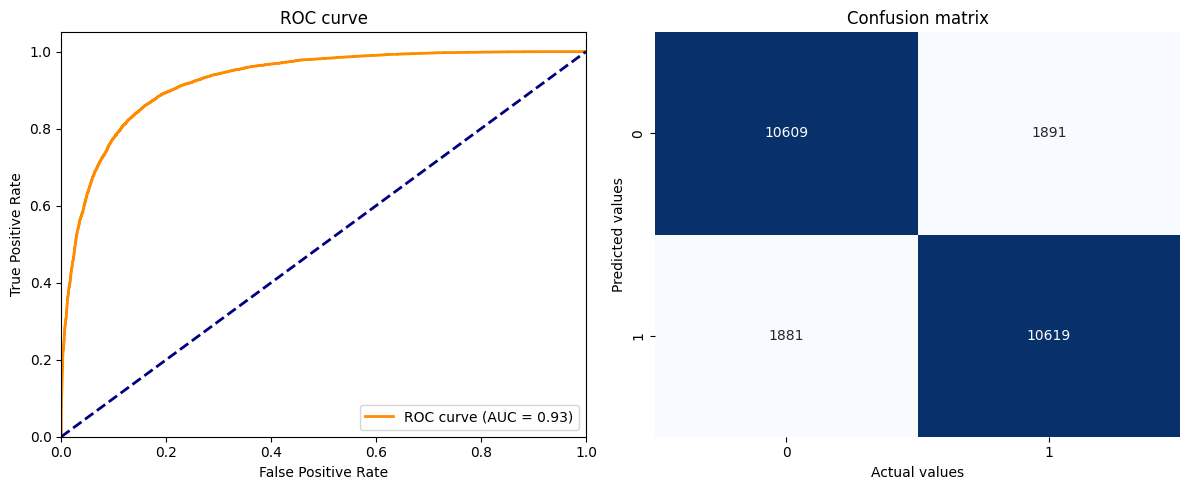

,Metric,Metric value
0,accuracy,0.849120
1,precision,0.848841
2,recall,0.849520
3,F1 Score,0.849180
4,ROC AUC,0.925750


In [44]:
smp.evaluate_model(pipeline, reviews_test_lemma_stemm, y_test)

### 4.3.3 TfidfVectorizer, Logistic Regression, Stemming, bigrams

In [53]:
param_dist = {
    "vectorizer__max_df": [0.9],
    "vectorizer__min_df": uniform(0.001, 0.01),
    "vectorizer__ngram_range": [(1, 2)], 
    "model__C": uniform(0.1, 2.0),  # Random selection of regularization parameter
    "model__penalty": ["l1", "l2"],  # type of regularization
    "model__solver": ['liblinear'], # I had to change the default solver because of a warning:
                                # ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty".
    "model__max_iter": [500]
}

pipeline = smp.get_pipeline_with_best_params(corpus=reviews_train_stemming_step_4, labels=y_train_binary,
                                             vectorizer=TfidfVectorizer(), model=LogisticRegression(), 
                                             param_distributions=param_dist) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'model__C': 0.666624020794882, 'model__max_iter': 500, 'model__penalty': 'l2', 'model__solver': 'liblinear', 'vectorizer__max_df': 0.9, 'vectorizer__min_df': 0.0013255381595820661, 'vectorizer__ngram_range': (1, 2)}

best score: 0.8807820884017902


In [54]:
pipeline.fit(reviews_train_stemming_step_4, y_train_binary)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.9, min_df=0.0013255381595820661,
                                 ngram_range=(1, 2))),
                ('model',
                 LogisticRegression(C=0.666624020794882, max_iter=500,
                                    solver='liblinear'))])

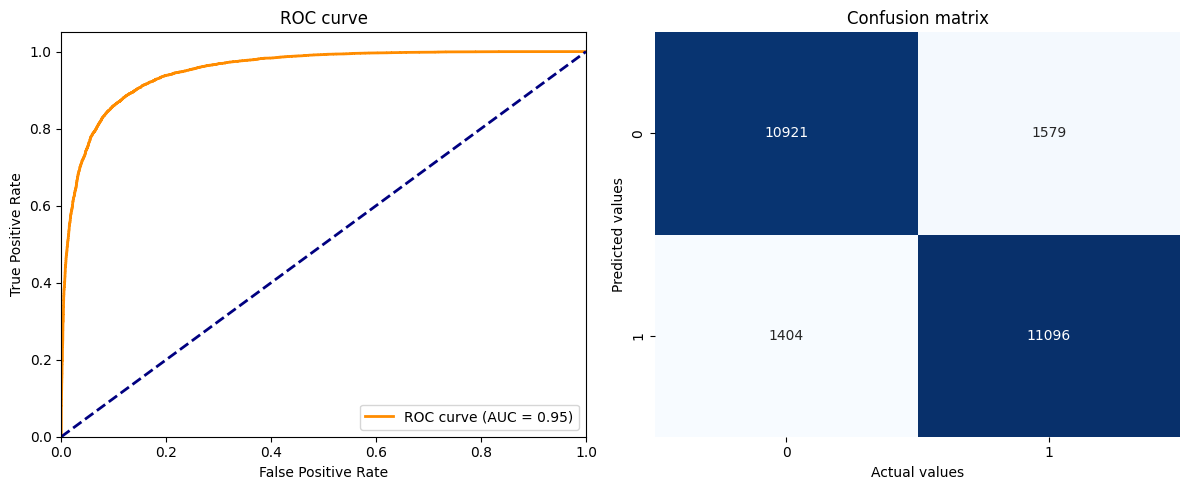

,Metric,Metric value
0,accuracy,0.880680
1,precision,0.875424
2,recall,0.887680
3,F1 Score,0.881509
4,ROC AUC,0.951522


In [55]:
smp.evaluate_model(pipeline, reviews_test_stemming, y_test)

### 4.3.4 TfidfVectorizer, Logistic Regression, Stemming + Lemmatization, bigrams

In [57]:
param_dist = {
    "vectorizer__max_df": [0.9],
    "vectorizer__min_df": uniform(0.001, 0.01),
    "vectorizer__ngram_range": [(1, 2)], 
    "model__C": uniform(0.1, 2.0),  # Random selection of regularization parameter
    "model__penalty": ["l1", "l2"],  # type of regularization
    "model__solver": ['liblinear'], # I had to change the default solver because of a warning:
                                # ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty".
    "model__max_iter": [500]
}

In [58]:
pipeline = smp.get_pipeline_with_best_params(corpus=reviews_train_lemma_stemm_step_4, labels=y_train_binary,
                                             vectorizer=TfidfVectorizer(), model=LogisticRegression(), 
                                             param_distributions=param_dist)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'model__C': 0.5179793533678979, 'model__max_iter': 500, 'model__penalty': 'l2', 'model__solver': 'liblinear', 'vectorizer__max_df': 0.9, 'vectorizer__min_df': 0.0018639281961902979, 'vectorizer__ngram_range': (1, 2)}

best score: 0.8756424130571674


In [59]:
pipeline.fit(reviews_train_lemma_stemm_step_4, y_train_binary)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.9, min_df=0.0018639281961902979,
                                 ngram_range=(1, 2))),
                ('model',
                 LogisticRegression(C=0.5179793533678979, max_iter=500,
                                    solver='liblinear'))])

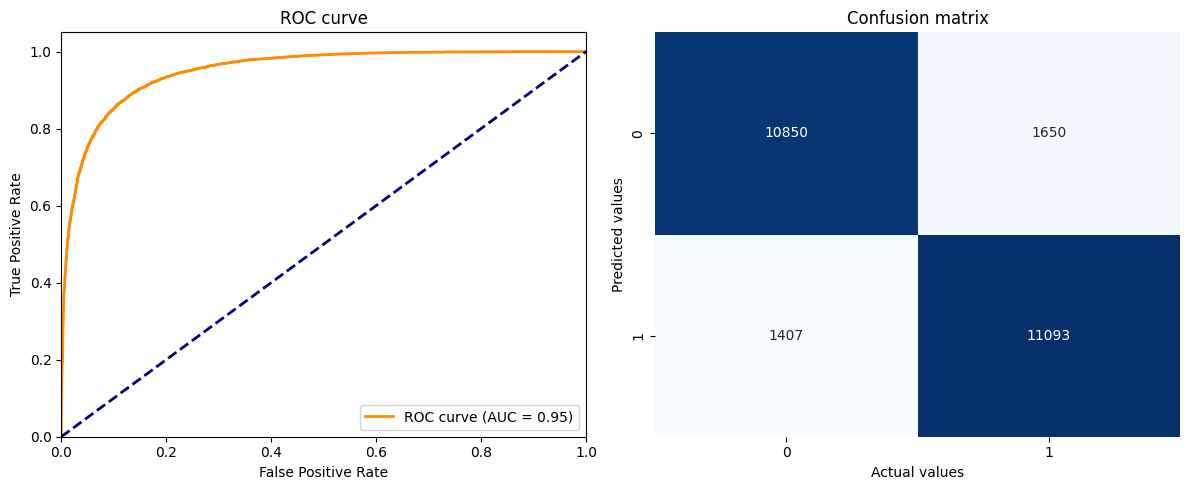

,Metric,Metric value
0,accuracy,0.877720
1,precision,0.870517
2,recall,0.887440
3,F1 Score,0.878897
4,ROC AUC,0.950054


In [60]:
smp.evaluate_model(pipeline, reviews_test_lemma_stemm, y_test)

### 4.3.5 TfidfVectorizer, SVC, Stemming, bigrams

In [ ]:
param_dist = {
    "vectorizer__max_df": [0.9],
    "vectorizer__min_df": uniform(0.001, 0.01),
    "vectorizer__ngram_range": [(1, 2)],
    "model__C": uniform(0.1, 2.0),  # Random selection of regularization parameter
    "model__kernel": ["linear", "rbf", "sigmoid"],  # Selection of the type of kernel 
    "model__probability": [True]
}

pipeline = smp.get_pipeline_with_best_params(corpus=reviews_train_stemming_step_4, labels=y_train_binary,
                                             vectorizer=TfidfVectorizer(), model=SVC(), 
                                             param_distributions=param_dist, cv=3)

In [9]:
# # Pipeline
# pipeline = Pipeline([
#     ("vectorizer", TfidfVectorizer(max_df=0.9, 
#                                    min_df=0.0016521385496845523, 
#                                   ngram_range=(1, 2))), 
#     ("model", SVC(C=1.1049110457839764, kernel="rbf", probability=True))
# ])

In [10]:
pipeline.fit(reviews_train_stemming_step_4, y_train_binary)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.9, min_df=0.0016521385496845523,
                                 ngram_range=(1, 2))),
                ('model', SVC(C=1.1049110457839764, probability=True))])

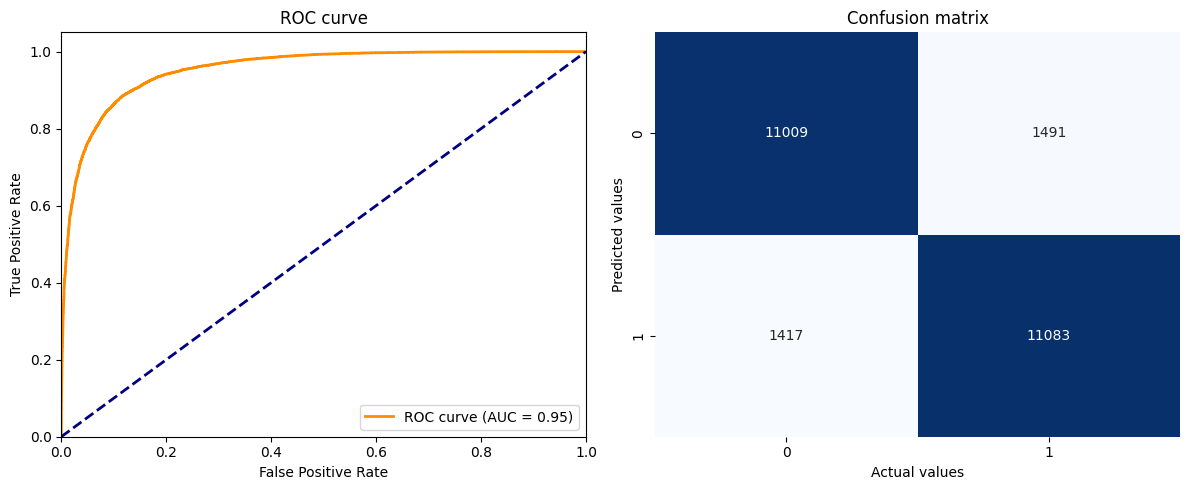

,Metric,Metric value
0,accuracy,0.883680
1,precision,0.881422
2,recall,0.886640
3,F1 Score,0.884023
4,ROC AUC,0.953064


In [11]:
smp.evaluate_model(pipeline, reviews_test_stemming, y_test)

# Summary 

By interpreting the results of comparisons of different models and data representations (CountVectorizer vs. TF-IDF with bigrams), several conclusions can be drawn:

- Logistic regression gives better results than Naive Bayes for both CountVectorizer and TF-IDF representations with bigrams. Metric values (accuracy, precision, sensitivity, F1-score, and ROC AUC) are higher for logistic regression.
- SVC gives better results than Logistic Regression in the same way. Here too, all checked metrics are higher than in the case of logistic regression.
- All three models Naive Bayes and logistic regression models and SVC perform better when using TF-IDF with bigrams compared to CountVectorizer. 
- At the same time, in none of the checked cases, additional lemmatization did not bring any benefits. Prediction scores were then similar to those without additional modification.
- For the problem of sentiment analysis of film reviews in English, no grounds for such an approach have been demonstrated. This only resulted in additional time overhead (lemmatization takes much longer than stemming).